In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [2]:
start_day_to_analyze = '2020-05-08'
end_day_to_analyze = '2020-05-09'

In [3]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [4]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [5]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [6]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [7]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,2974,549,AGRX,buy,793,2.57,"{'avg': 2.5534, 'rsi': 61.918887134879206, 'ma...",2020-05-08 15:10:13.083150+00:00,2020-05-08 15:10:13.254775,2.50,2.78
1,2975,549,AGRX,buy,561,2.57,"{'avg': 2.5534, 'rsi': 61.918887134879206, 'ma...",2020-05-08 15:10:13.129575+00:00,2020-05-08 15:10:13.334084,2.50,2.78
2,2990,549,AGRX,sell,1354,2.57,"{'avg': 2.5542, 'rsi': [60.61876695530914, 60....",2020-05-08 15:22:06.631481+00:00,2020-05-08 15:22:07.175591,2.50,2.78
3,2995,549,AMX,buy,773,12.68,"{'avg': 12.671, 'rsi': 65.31688384750987, 'mac...",2020-05-08 15:25:22.236495+00:00,2020-05-08 15:25:22.683513,12.59,12.95
4,2996,549,AMX,buy,285,12.68,"{'avg': 12.671, 'rsi': 65.31688384750987, 'mac...",2020-05-08 15:25:22.277668+00:00,2020-05-08 15:25:22.728276,12.59,12.95
...,...,...,...,...,...,...,...,...,...,...,...
129,3003,549,X,sell,84,8.51,"{'avg': 8.3985, 'rsi': [64.22290343706891, 65....",2020-05-08 15:29:10.552289+00:00,2020-05-08 15:29:10.840957,8.33,9.01
130,3004,549,X,sell,473,8.51,"{'avg': 8.3985, 'rsi': [64.22290343706891, 65....",2020-05-08 15:29:10.601129+00:00,2020-05-08 15:29:11.013408,8.33,9.01
131,3008,549,XME,buy,713,20.07,"{'avg': 19.9374, 'rsi': 65.30994925091304, 'ma...",2020-05-08 15:31:16.603952+00:00,2020-05-08 15:31:17.170926,19.95,20.43
132,3009,549,XME,buy,80,20.07,"{'avg': 19.9374, 'rsi': 65.30994925091304, 'ma...",2020-05-08 15:31:16.531031+00:00,2020-05-08 15:31:17.650828,19.95,20.43


In [8]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))

In [9]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [10]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
5,549,momentum_long,PAPER,v0.1-377-g7f1cc98,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 240}",2020-05-08 15:01:26.851100,None,None


,symbol,count,revenue
42,ORC,1,-8251.60
34,PINS,2,-124.53
2,RIOT,5,-112.22
30,RUN,2,-109.80
12,AMX,4,-105.80
25,KIM,2,-98.54
22,PBYI,3,-96.88
8,SLB,4,-91.00
9,TME,4,-88.34
0,NAIL,6,-68.74


TOTAL REVENUE: -7906.42 $


In [11]:

minute_history = {}
minute_history1 = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    for symbol, count in symbols.items():
        if symbol not in minute_history:
            minute_history[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date()).df
            minute_history1[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=20)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')-timedelta(days=11)).date()).df

In [12]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    for back_track_min in range(200, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].between_time("9:30", "16:00").dropna().resample("5min").max()
        ).dropna()
        #print(series[0:10])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(200, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

NAIL analysis for run 549 with profit -68.74


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4723.53,-4723.53,buy,2020-05-08 15:20:42.271521,18.97,"[18.6001, 18.72]","[19.1071, 19.32]",249,"{'avg': 18.7679, 'rsi': 56.99454840442081, 'macd': [0.011134631921969174, 0.018353306272317127, 0.024198668726036487, 0.028103739950733342, 0.031241858546142254], 'vwap': 18.97, 'supports': [18.29, 18.6001, 18.72, 18.9342], 'sell_macd': [0.009705624525150114, 0.014211494364769095, 0.017797737170127448, 0.020101332379883985, 0.021895025629305565], 'slow macd': [0.01871288770312063, 0.01979004456975275, 0.020829379944341753, 0.021672320039165527, 0.022493158055173268], 'macd_signal': [-0.008179755771195544, -0.0028731433624930094, 0.0025412190552128906, 0.007653723234316981, 0.012371350296682036], 'resistances': [19.1071, 19.32], 'position_ratio': '3.83', 'sell_macd_signal': [-0.0025882711706845148, 0.0007716819364062075, 0.004176892983150457, 0.007361780862497162, 0.010268429815858843]}",20.11,18.59
1,-4.98,4718.55,sell,2020-05-08 15:32:51.970812,18.95,None,None,249,"{'avg': 18.7743, 'rsi': [50.93859507800232, 54.89067541881999], 'vwap': 18.9701, 'reasons': 'bail', 'movement': 5.271481286229148e-06, 'sell_macd': [0.025694476204581207, 0.02143005658574637, 0.01821843017385305, 0.015609131279209265, 0.015456312253785853], 'sell_macd_signal': [0.021197295275704804, 0.021243847537713117, 0.020638764064941105, 0.019632837507794737, 0.01879753245699296]}",20.11,18.59
2,-13338.00,-13333.02,buy,2020-05-08 15:45:55.509122,19.02,"[18.915, 18.92]","[19.1071, 19.32]",701,"{'avg': 18.7809, 'rsi': 58.243362059159075, 'macd': [0.01784154359022594, 0.02004898597578375, 0.022323774329418455, 0.02387554555429361, 0.026015815937839193], 'vwap': 19.025, 'supports': [18.6001, 18.72, 18.87, 18.915, 18.92, 18.9342], 'sell_macd': [0.010450109288001386, 0.011847730012416235, 0.013286814602704311, 0.014251207600295857, 0.01559682282439212], 'slow macd': [0.024256707853851367, 0.024673044495205687, 0.02517176438076163, 0.025595141989377623, 0.026183631117511652], 'macd_signal': [0.02191566465413961, 0.021542328918468436, 0.02169861800065844, 0.022134003511385475, 0.02291036599667622], 'resistances': [19.1071, 19.32], 'position_ratio': '0.9', 'sell_macd_signal': [0.01352233772427952, 0.013187416181906863, 0.013207295866066353, 0.013416078212912253, 0.013852227135208227]}",19.43,18.89
3,-117.14,13220.86,sell,2020-05-08 15:53:04.787440,18.86,None,None,701,"{'avg': 18.7855, 'rsi': [50.11015326693647, 38.72585294876598], 'vwap': 18.8639, 'reasons': 'stopped', 'movement': -0.008412197686645645, 'sell_macd': [0.01255888967051888, 0.012330474730319452, 0.011566379001198612, 0.009516870913554243, 0.0022533987554744783], 'sell_macd_signal': [0.012852688301476619, 0.012748245587245185, 0.01251187227003587, 0.011912871998739544, 0.009980977350086531]}",19.43,18.89
4,-8499.14,-8382.00,buy,2020-05-08 16:14:38.475902,19.05,"[18.86, 18.915, 18.92]","[19.1071, 19.32]",440,"{'avg': 18.7994, 'rsi': 58.36379652044476, 'macd': [0.004167386314534838, 0.010282267789445854, 0.014238003785010278, 0.017174970689968205, 0.020875728570604934], 'vwap': 19.05, 'supports': [18.6001, 18.72, 18.86, 18.87, 18.915, 18.92, 18.9342], 'sell_macd': [0.0022704362945233925, 0.006263043178744709, 0.008825294735558487, 0.010707240172873611, 0.013073597134766857], 'slow macd': [0.01406140206090356, 0.015047982879430322, 0.015787659221658146, 0.01644293496199367, 0.01733938347805619], 'macd_signal': [0.004478356465087926, 0.005639138729959511, 0.007358911740969665, 0.009322123530769373, 0.011632844538736486], 'resistances': [19.32], 'position_ratio': '2.33', 'sell_macd_signal': [0.002373084508816917, 0.0031510762428024757, 0.004285919941353678, 0.005570183987657665, 0.007070866617079503]}",19.70,18.83
5,-68.74,8430.40,sell,2020-05-08 16:49:40.827884,19.16,None,None,440,"{'avg': 18.8163, 'rsi': [65.73617987221274, 63.203786254271456], 'vwap': 19.17, 'reasons': 'bail', 'movement': 0.006299212598425249, 'sell_macd

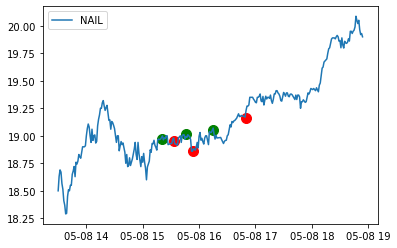

QRTEA analysis for run 549 with profit 98.7


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4812.90,-4812.90,buy,2020-05-08 15:14:20.516053,7.89,[7.755],"[7.925, 7.925]",610,"{'avg': 7.749, 'rsi': 66.05530027424524, 'macd': [-0.0060072862645119685, -0.0011230563816928552, 0.002716417815747718, 0.008086758935500704, 0.012600994753706907], 'vwap': 7.89, 'supports': [7.42, 7.61, 7.69, 7.755, 7.795, 7.87], 'sell_macd': [-0.0030725450828406053, 0.00011358839930686315, 0.0025948146399512595, 0.0060529803516224945, 0.00892878505744843], 'slow macd': [0.009220462558548803, 0.009649545428977113, 0.010028882295485708, 0.010841652627615161, 0.011652055635899217], 'macd_signal': [-0.01507832396613758, -0.012287270449248636, -0.009286532796249365, -0.005811874449899351, -0.0021293006091780992], 'resistances': [7.925, 7.925, 7.93, 7.935], 'position_ratio': '1.75', 'sell_macd_signal': [-0.00932128965879386, -0.0074343140471737155, -0.00542848830974872, -0.003132194577474477, -0.0007199986504898954]}",8.35,7.74
1,0.00,4812.90,sell,2020-05-08 15:42:09.009077,7.89,None,None,610,"{'avg': 7.7592, 'rsi': [52.774949584674445, 54.076989384114135], 'vwap': 7.895, 'reasons': 'bail', 'movement': 0.000633713561470202, 'sell_macd': [0.004822380713419783, 0.005060871368943509, 0.004401761861962505, 0.004090744559614556, 0.0040550071219449535], 'sell_macd_signal': [0.008647166451072144, 0.007929907434646418, 0.007224278320109636, 0.006597571568010619, 0.006089058678797487]}",8.35,7.74
2,-6820.46,-6820.46,buy,2020-05-08 15:51:30.202900,7.94,[7.855],"[8.005, 8.025]",859,"{'avg': 7.7632, 'rsi': 64.73889454373548, 'macd': [0.014009342878750886, 0.014206567183992824, 0.0141991894495348, 0.01482931584618985, 0.015552869964980509], 'vwap': 7.94, 'supports': [7.69, 7.755, 7.795, 7.855, 7.855, 7.87], 'sell_macd': [0.008175464118038711, 0.008296039709485115, 0.008282253940359752, 0.008683430562594907, 0.009143004157030177], 'slow macd': [0.01613503805323724, 0.016265657060733574, 0.016359816080328216, 0.016580216176195428, 0.016836441588385043], 'macd_signal': [0.011991488433642259, 0.012434504183712372, 0.012787441236876858, 0.013195816158739456, 0.013667226919987667], 'resistances': [8.005], 'position_ratio': '0.93', 'sell_macd_signal': [0.006868485861770525, 0.0071539966313134435, 0.007379648093122705, 0.007640404587017145, 0.007940924501019752]}",8.27,7.83
3,42.95,6863.41,sell,2020-05-08 16:06:12.036142,7.99,None,None,859,"{'avg': 7.7739, 'rsi': [63.17594473932965, 63.17594473932964], 'vwap': 7.99, 'reasons': 'bail', 'movement': 0.0062972292191435545, 'sell_macd': [0.015307422851679853, 0.014325969711658892, 0.013894629995906627, 0.013637811646022513, 0.013260579014346519], 'sell_macd_signal': [0.013148052099938821, 0.013383635622282836, 0.013485834497007593, 0.013516229926810577, 0.013465099744317765]}",8.27,7.83
4,-8999.70,-9042.65,buy,2020-05-08 17:05:23.416997,8.11,"[7.855, 7.96, 8.03, 8.055]","[8.27, 8.35]",1115,"{'avg': 7.8062, 'rsi': 68.6497132028065, 'macd': [0.012371522185791406, 0.011287050346853178, 0.01070762596766528, 0.012524799163825762, 0.015401219198837524], 'vwap': 8.125, 'supports': [7.855, 7.855, 7.96, 8.03, 8.055], 'sell_macd': [0.006796559817223269, 0.0061041132214345595, 0.005745010507554937, 0.006949021243395137, 0.008835925436992298], 'slow macd': [0.021077010663418605, 0.02078304484896698, 0.020559315333393613, 0.020800403347518426, 0.021308816745005288], 'macd_signal': [0.014830035094686774, 0.014121438145120055, 0.0134386757096291, 0.013255900400468432, 0.013684964160142251], 'resistances': [8.27], 'position_ratio': '2.07', 'sell_macd_signal': [0.008390654548854955, 0.007933346283370876, 0.007495679128207688, 0.007386347551245178, 0.007676263128394601]}",8.38,8.04
5,98.70,9098.40,sell,2020-05-08 17:30:23.125128,8.16,None,None,1115,"{'avg': 7.8162, 'rsi': [62.09504396912222, 59.6496671219821], 'vwap': 8.16, 'reasons': 'bail', 'movement': 0.006165228113440285, 'sell_macd': [0.015288410304814093, 0.015129042687020089, 0.014808379053842

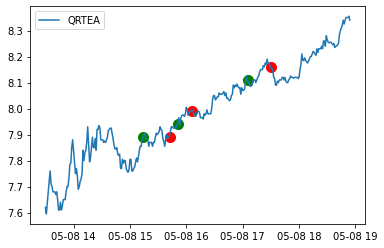

RIOT analysis for run 549 with profit -112.22


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1888.92,-1888.92,buy,2020-05-08 15:32:07.747447,1.98,"[1.902, 1.905, 1.94]",[2.1],954,"{'avg': 1.8626, 'rsi': 59.45161965954661, 'macd': [-0.0016915433699384863, -0.00022542147177784244, 0.0018352201461178108, 0.003412814346507531, 0.006285142402693289], 'vwap': 1.98, 'supports': [1.665, 1.67, 1.795, 1.902, 1.905, 1.94], 'sell_macd': [-0.0017217392485491256, -0.0006897037632875858, 0.000715644715660213, 0.0017910377548966405, 0.0036966552172250644], 'slow macd': [0.022974998053830076, 0.022587851048845975, 0.022377864378448464, 0.02214568093738567, 0.02223251147651606], 'macd_signal': [-0.006019309843037101, -0.004860532168785249, -0.0035213817058046366, -0.0021345424953422027, -0.00045060551573510433], 'resistances': [2.1], 'position_ratio': '2.21', 'sell_macd_signal': [-0.005074470512026989, -0.004197517162279108, -0.0032148847866912437, -0.002213700278373667, -0.0010316291792539206]}",2.29,1.89
1,-124.02,1764.90,sell,2020-05-08 15:39:05.029730,1.85,None,None,954,"{'avg': 1.8648, 'rsi': [43.69514266741688, 35.38394994865419], 'vwap': 1.8787, 'reasons': 'stopped', 'movement': -0.055050505050505044, 'sell_macd': [0.003307451922427873, 0.00261954876439785, 0.0023040456702911882, 0.00033996474410047384, -0.0038702277275299846], 'sell_macd_signal': [0.0012833309393609654, 0.0015505745043683423, 0.0017012687375529115, 0.001429007938862424, 0.0003691608055839421]}",2.29,1.89
2,-2413.22,-2289.20,buy,2020-05-08 16:09:05.010346,1.94,"[1.83, 1.87]","[1.99, 2.1]",1180,"{'avg': 1.8656, 'rsi': 60.05524701579692, 'macd': [-0.0008500837899951819, 0.0012705429986563654, 0.003882765776105135, 0.005773450108566669, 0.007587821592876187], 'vwap': 1.9281, 'supports': [1.7045, 1.795, 1.83, 1.87, 1.902, 1.905, 1.94], 'sell_macd': [0.00013370216122665646, 0.00147577526742948, 0.0031309520350233377, 0.004307311178148199, 0.005427755819827906], 'slow macd': [0.0008398207389015422, 0.001147826577660327, 0.0016228886043190283, 0.002034974237635545, 0.0024908195576318626], 'macd_signal': [-0.003662749715885462, -0.0026760911729770964, -0.0013643197831606502, 6.323419518481374e-05, 0.0015681516747230886], 'resistances': [1.99, 2.1], 'position_ratio': 'inf', 'sell_macd_signal': [-0.0016082094304199549, -0.0009914124908500677, -0.00016693958567538662, 0.0007279105670893305, 0.0016678796176370458]}",2.18,1.86
3,-1461.62,951.60,sell,2020-05-08 16:21:25.968721,1.95,None,None,488,"{'avg': 1.8676, 'rsi': [59.94427453667272, 58.83328129500518], 'vwap': 1.9605, 'reasons': 'bail', 'movement': 0.010309278350515474, 'sell_macd': [0.010918802711184838, 0.010738172448049754, 0.010198224548878754, 0.009759327165773213, 0.00917629898197947], 'sell_macd_signal': [0.008890810540415373, 0.00926028292194225, 0.009447871247329551, 0.009510162431018283, 0.00944338974121052]}",2.18,1.86
4,-112.22,1349.40,sell,2020-05-08 16:21:26.030648,1.95,None,None,692,"{'avg': 1.8676, 'rsi': [59.94427453667272, 58.83328129500518], 'vwap': 1.9605, 'reasons': 'bail', 'movement': 0.010309278350515474, 'sell_macd': [0.010918802711184838, 0.010738172448049754, 0.010198224548878754, 0.009759327165773213, 0.00917629898197947], 'sell_macd_signal': [0.008890810540415373, 0.00926028292194225, 0.009447871247329551, 0.009510162431018283, 0.00944338974121052]}",2.18,1.86


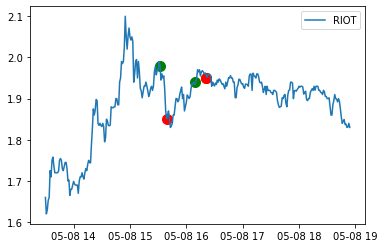

OXY analysis for run 549 with profit 7.01


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4225.32,-4225.32,buy,2020-05-08 15:14:12.677032,14.52,"[14.25, 14.385]","[14.61, 14.6399]",291,"{'avg': 14.4256, 'rsi': 67.03992359757272, 'macd': [0.012984640079690024, 0.020980822280700195, 0.029000841699945212, 0.032967513989097696, 0.036489351093258904], 'vwap': 14.52, 'supports': [14.12, 14.25, 14.3201, 14.385, 14.495, 14.5175], 'sell_macd': [0.00944585196584491, 0.014514428536999802, 0.01957417094910774, 0.02196911086829445, 0.024064270404435817], 'slow macd': [0.007418048602998439, 0.009168581827553979, 0.01116430458740858, 0.012584336915306693, 0.014029021856863721], 'macd_signal': [0.00625036886450357, 0.009196459547742895, 0.013157335978183358, 0.017119371580366225, 0.02099336748294476], 'resistances': [14.61, 14.6399], 'position_ratio': '36.0', 'sell_macd_signal': [0.005537433180012596, 0.007332832251410037, 0.009781099990949577, 0.012218702166418552, 0.014587815814022005]}",15.49,14.20
1,0.00,4225.32,sell,2020-05-08 15:23:59.977102,14.52,None,None,291,"{'avg': 14.4296, 'rsi': [61.96501436678879, 63.64708424628438], 'vwap': 14.5201, 'reasons': 'bail', 'movement': 6.887052341581746e-06, 'sell_macd': [0.021938087926516303, 0.022494808968396285, 0.022376736936505992, 0.021474645263131364, 0.021017500514227905], 'sell_macd_signal': [0.02010988103807758, 0.02058686662414132, 0.020944840686614254, 0.021050801601917676, 0.02104414138437972]}",15.49,14.20
2,-10178.52,-10178.52,buy,2020-05-08 16:01:07.439382,14.52,[14.425],"[14.535, 14.57]",701,"{'avg': 14.4387, 'rsi': 66.26502055467412, 'macd': [-0.006889613501078529, -0.005168461276905845, -0.002157661542561584, 0.001964847212752474, 0.006225333021470547], 'vwap': 14.525, 'supports': [14.25, 14.3201, 14.385, 14.415, 14.425, 14.495, 14.5175], 'sell_macd': [-0.004375421346329844, -0.0032085678371025494, -0.0012135057800790605, 0.0014893153783805957, 0.004261782315124307], 'slow macd': [0.006769341696848841, 0.006661722303082485, 0.006873525935922942, 0.007406059344727822, 0.008095277711893445], 'macd_signal': [-0.009305131132069997, -0.008477797161037167, -0.00721377003734205, -0.005378046587323145, -0.0030573706655644063], 'resistances': [14.535, 14.57, 14.61], 'position_ratio': '1.33', 'sell_macd_signal': [-0.006292563417024723, -0.005675764301040288, -0.004783312596848043, -0.003528787001802315, -0.0019706731384169906]}",14.93,14.39
3,-2695.57,7482.95,sell,2020-05-08 16:27:13.746280,14.53,None,None,515,"{'avg': 14.4443, 'rsi': [56.48365773033761, 55.054140010459285], 'vwap': 14.5308, 'reasons': 'bail', 'movement': 0.000688705234159765, 'sell_macd': [0.01172263507388216, 0.011710814322656304, 0.01094172264218507, 0.01046007038932295, 0.009689171615802294], 'sell_macd_signal': [0.00879894748418033, 0.009381320851875524, 0.009693401209937433, 0.009846735045814537, 0.009815222359812088]}",14.93,14.39
4,7.01,2702.58,sell,2020-05-08 16:27:13.807006,14.53,None,None,186,"{'avg': 14.4443, 'rsi': [56.48365773033761, 55.054140010459285], 'vwap': 14.5308, 'reasons': 'bail', 'movement': 0.000688705234159765, 'sell_macd': [0.01172263507388216, 0.011710814322656304, 0.01094172264218507, 0.01046007038932295, 0.009689171615802294], 'sell_macd_signal': [0.00879894748418033, 0.009381320851875524, 0.009693401209937433, 0.009846735045814537, 0.009815222359812088]}",14.93,14.39


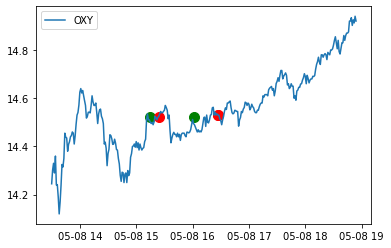

HPE analysis for run 549 with profit 71.16


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-9046.04,-9046.04,buy,2020-05-08 15:14:11.282947,10.04,"[9.94, 9.97]","[10.095, 10.095, 10.11]",901,"{'avg': 9.9415, 'rsi': 63.79696917559914, 'macd': [0.011145596288988813, 0.013322751140274036, 0.013991202933841151, 0.014754335217304515, 0.015582950707569765], 'vwap': 10.0402, 'supports': [9.55, 9.935, 9.94, 9.97, 9.985], 'sell_macd': [0.007045524763180211, 0.008427920538720102, 0.008819035162014544, 0.009269007139101504, 0.0097589981973627], 'slow macd': [0.016745623810189514, 0.01709904593962186, 0.017219329080791823, 0.01738242152041991, 0.017584639040412853], 'macd_signal': [0.005807781714823249, 0.0073107755999134065, 0.008646861066698956, 0.009868355896820068, 0.011011274858970008], 'resistances': [10.11], 'position_ratio': '1.08', 'sell_macd_signal': [0.0035851177647455096, 0.004553678319540428, 0.005406749688035251, 0.0061792011782485015, 0.006895160582071342]}",10.36,9.94
1,0.00,9046.04,sell,2020-05-08 15:33:05.741538,10.04,None,None,901,"{'avg': 9.9529, 'rsi': [55.41698057836053, 57.48897310552699], 'vwap': 10.045, 'reasons': 'bail', 'movement': 0.0004980079681275679, 'sell_macd': [0.005388692381817606, 0.0055372657040706486, 0.005768137569409859, 0.005353646327215245, 0.005220878523852335], 'sell_macd_signal': [0.005437539198325383, 0.005457484499474436, 0.005519615113461521, 0.005486421356212265, 0.005433312789740279]}",10.36,9.94
2,-13235.04,-13235.04,buy,2020-05-08 17:23:08.623323,10.08,"[9.985, 10.02, 10.04, 10.04, 10.055, 10.0647]",[10.105],1313,"{'avg': 9.9898, 'rsi': 67.7592563213271, 'macd': [-0.000320665274726295, 0.0016222224622044479, 0.0031259410884345584, 0.004268444956981199, 0.005114925823141547], 'vwap': 10.08, 'supports': [9.985, 10.02, 10.04, 10.04, 10.055, 10.0647], 'sell_macd': [-0.0001780120833423382, 0.001086692860312155, 0.002058064337701282, 0.0027882490689439265, 0.003321013157327357], 'slow macd': [0.002525456552383787, 0.0028274319512551216, 0.003100736895277123, 0.0033472269906837937, 0.003568652341172651], 'macd_signal': [-0.00016341820402366127, 0.00019370992922196058, 0.0007801561610644802, 0.0014778139202478238, 0.0022052363008265687], 'resistances': [10.105], 'position_ratio': '1.63', 'sell_macd_signal': [-7.802881635654028e-05, 0.00015491551897719882, 0.0005355452827220155, 0.0009860860399663978, 0.0014530714634385896]}",10.20,10.04
3,-23909.76,-10674.72,buy,2020-05-08 17:23:08.726336,10.08,"[9.985, 10.02, 10.04, 10.04, 10.055, 10.0647]",[10.105],1059,"{'avg': 9.9898, 'rsi': 67.7592563213271, 'macd': [-0.000320665274726295, 0.0016222224622044479, 0.0031259410884345584, 0.004268444956981199, 0.005114925823141547], 'vwap': 10.08, 'supports': [9.985, 10.02, 10.04, 10.04, 10.055, 10.0647], 'sell_macd': [-0.0001780120833423382, 0.001086692860312155, 0.002058064337701282, 0.0027882490689439265, 0.003321013157327357], 'slow macd': [0.002525456552383787, 0.0028274319512551216, 0.003100736895277123, 0.0033472269906837937, 0.003568652341172651], 'macd_signal': [-0.00016341820402366127, 0.00019370992922196058, 0.0007801561610644802, 0.0014778139202478238, 0.0022052363008265687], 'resistances': [10.105], 'position_ratio': '1.63', 'sell_macd_signal': [-7.802881635654028e-05, 0.00015491551897719882, 0.0005355452827220155, 0.0009860860399663978, 0.0014530714634385896]}",10.20,10.04
4,71.16,23980.92,sell,2020-05-08 17:41:57.314394,10.11,None,None,2372,"{'avg': 9.9996, 'rsi': [71.89728393138967, 54.535168359850786], 'vwap': 10.1197, 'reasons': 'bail', 'movement': 0.0029761904761904127, 'sell_macd': [0.009225253749072237, 0.009001128599368968, 0.00922906837103632, 0.00954656600647752, 0.008371284085958663], 'sell_macd_signal': [0.008181175754754934, 0.008345166323677742, 0.008521946733149457, 0.008726870587815069, 0.008655753287443788]}",10.20,10.04


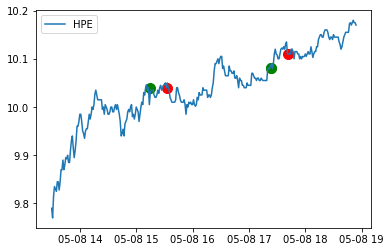

STL analysis for run 549 with profit 132.31


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-8338.69,-8338.69,buy,2020-05-08 15:10:15.022084,11.47,"[11.29, 11.35]","[11.63, 11.655]",727,"{'avg': 11.4364, 'rsi': 59.692584632810785, 'macd': [-0.008405590463608448, -0.003602719334022453, 0.0009989913154715424, 0.0045929356554985645, 0.008154083663718836], 'vwap': 11.47, 'supports': [10.69, 11.29, 11.35], 'sell_macd': [-0.0038796325745167337, -0.0008055019057682244, 0.0021198661725527757, 0.004371843036537371, 0.006589333540464537], 'slow macd': [0.008258682724388677, 0.00854017746837954, 0.008945438842248521, 0.009303985290031846, 0.009778915092187646], 'macd_signal': [-0.0137578235789427, -0.01172680272995865, -0.009181643920872612, -0.006426728005598377, -0.0035105656717349344], 'resistances': [11.63, 11.655], 'position_ratio': '1.33', 'sell_macd_signal': [-0.007294599496222143, -0.00599677997813136, -0.004373450747994533, -0.002624391991088152, -0.0007816468847776138]}",11.86,11.33
1,94.51,8433.20,sell,2020-05-08 15:27:08.847130,11.60,None,None,727,"{'avg': 11.4448, 'rsi': [63.92797801214887, 65.5617912963899], 'vwap': 11.5992, 'reasons': 'bail', 'movement': 0.011333914559720925, 'sell_macd': [0.03174298596887937, 0.030531836012238855, 0.029711045967944827, 0.027906390790988667, 0.02665722583763319], 'sell_macd_signal': [0.025479002263903712, 0.02648956901357074, 0.027133864404445557, 0.02728836968175418, 0.027162140912929983]}",11.86,11.33
2,-10839.14,-10933.65,buy,2020-05-08 16:44:23.323991,11.57,"[11.485, 11.5, 11.55]","[11.595, 11.6, 11.61, 11.62]",945,"{'avg': 11.4598, 'rsi': 56.2793634597071, 'macd': [0.0054578844204424826, 0.0060476077821558505, 0.0064407231478025295, 0.006635434922621641, 0.0075499762285620164], 'vwap': 11.5617, 'supports': [11.29, 11.35, 11.485, 11.5, 11.55], 'sell_macd': [0.0039770144491875214, 0.004320861678062116, 0.004532679496950465, 0.004612892349371123, 0.005160942723344775], 'slow macd': [0.0034547910316788943, 0.003628105780054014, 0.003781758244226552, 0.003909078231064456, 0.004187897494075443], 'macd_signal': [-0.0023401548701961704, -0.0006626023397257662, 0.0007580627577798932, 0.0019335371907482429, 0.0030568249983109978], 'resistances': [11.595, 11.6, 11.61, 11.62, 11.62], 'position_ratio': '1.25', 'sell_macd_signal': [-0.0011564891065787295, -6.101894965056037e-05, 0.0008577207396696447, 0.0016087550616099404, 0.0023191925939569074]}",11.87,11.47
3,-88.28,10750.86,sell,2020-05-08 17:09:53.783848,11.61,None,None,926,"{'avg': 11.4641, 'rsi': [56.50420884012992, 56.50420884012992], 'vwap': 11.61, 'reasons': 'bail', 'movement': 0.003457216940362934, 'sell_macd': [0.01328111661811704, 0.013937852446652244, 0.01271014202152898, 0.011588417767905312, 0.010563847988874997], 'sell_macd_signal': [0.009278023470436058, 0.010209989265679295, 0.010710019816849232, 0.010885699407060448, 0.010821329123423358]}",11.87,11.47
4,132.31,220.59,sell,2020-05-08 17:09:53.819758,11.61,None,None,19,"{'avg': 11.4641, 'rsi': [56.50420884012992, 56.50420884012992], 'vwap': 11.61, 'reasons': 'bail', 'movement': 0.003457216940362934, 'sell_macd': [0.01328111661811704, 0.013937852446652244, 0.01271014202152898, 0.011588417767905312, 0.010563847988874997], 'sell_macd_signal': [0.009278023470436058, 0.010209989265679295, 0.010710019816849232, 0.010885699407060448, 0.010821329123423358]}",11.87,11.47


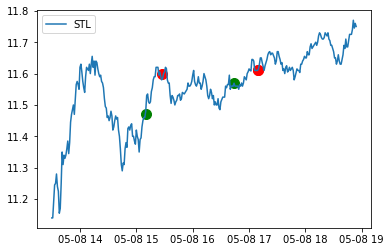

WTRH analysis for run 549 with profit 67.65


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2638.34,-2638.34,buy,2020-05-08 16:13:12.497267,2.62,"[2.56, 2.57]","[2.6851, 2.7, 2.7069]",1007,"{'avg': 2.4639, 'rsi': 64.23235857723027, 'macd': [-0.002558391284777084, -0.0015421530134842598, 0.001664781848793595, 0.004158365779651341, 0.006064639619729029], 'vwap': 2.62, 'supports': [2.545, 2.56, 2.57, 2.57, 2.605], 'sell_macd': [-0.0010839373805020536, -0.00044821762952373945, 0.0016114109768166074, 0.0031953889690714554, 0.004388158976424528], 'slow macd': [-2.3747584729783e-05, 3.524345527639028e-05, 0.0005692688088281272, 0.0010596787501664373, 0.0015091767749639828], 'macd_signal': [-0.003569599455835536, -0.003164110167365281, -0.0021983317641335056, -0.0009269922553765361, 0.0004713341196445769], 'resistances': [2.6851, 2.7, 2.7069], 'position_ratio': '4.34', 'sell_macd_signal': [-0.0016589961477563495, -0.0014168404441098274, -0.0008111901599245405, -9.874334125341212e-06, 0.0008697323279846326]}",2.83,2.55
1,-3544.86,-906.52,buy,2020-05-08 16:13:12.583135,2.62,"[2.56, 2.57]","[2.6851, 2.7, 2.7069]",346,"{'avg': 2.4639, 'rsi': 64.23235857723027, 'macd': [-0.002558391284777084, -0.0015421530134842598, 0.001664781848793595, 0.004158365779651341, 0.006064639619729029], 'vwap': 2.62, 'supports': [2.545, 2.56, 2.57, 2.57, 2.605], 'sell_macd': [-0.0010839373805020536, -0.00044821762952373945, 0.0016114109768166074, 0.0031953889690714554, 0.004388158976424528], 'slow macd': [-2.3747584729783e-05, 3.524345527639028e-05, 0.0005692688088281272, 0.0010596787501664373, 0.0015091767749639828], 'macd_signal': [-0.003569599455835536, -0.003164110167365281, -0.0021983317641335056, -0.0009269922553765361, 0.0004713341196445769], 'resistances': [2.6851, 2.7, 2.7069], 'position_ratio': '4.34', 'sell_macd_signal': [-0.0016589961477563495, -0.0014168404441098274, -0.0008111901599245405, -9.874334125341212e-06, 0.0008697323279846326]}",2.83,2.55
2,-1739.94,1804.92,sell,2020-05-08 16:19:31.485645,2.67,None,None,676,"{'avg': 2.466, 'rsi': [75.73582628215709, 78.53665148959463], 'vwap': 2.6721, 'reasons': 'scale-out', 'movement': 0.022442748091602953, 'sell_macd': [0.008166456395555244, 0.009816689899694087, 0.011234836917208835, 0.01245371982803567, 0.013958645215328858], 'sell_macd_signal': [0.0033983278290721252, 0.004682000243196517, 0.005992567577998981, 0.007284798028006319, 0.008619567465470827]}",2.83,2.55
3,-725.34,1014.60,sell,2020-05-08 16:28:06.121098,2.67,None,None,380,"{'avg': 2.4687, 'rsi': [69.28504993056505, 69.28504993056505], 'vwap': 2.675, 'reasons': 'bail', 'movement': 0.0018726591760299227, 'sell_macd': [0.015333731605829293, 0.014905222375387162, 0.014580342164972837, 0.013878093401468394, 0.013150651593524021], 'sell_macd_signal': [0.01301925021743205, 0.013396444649023072, 0.013633224152213025, 0.013682198002064098, 0.013575888720356083]}",2.83,2.55
4,67.65,792.99,sell,2020-05-08 16:28:06.283986,2.67,None,None,297,"{'avg': 2.4687, 'rsi': [69.28504993056505, 69.28504993056505], 'vwap': 2.675, 'reasons': 'bail', 'movement': 0.0018726591760299227, 'sell_macd': [0.015333731605829293, 0.014905222375387162, 0.014580342164972837, 0.013878093401468394, 0.013150651593524021], 'sell_macd_signal': [0.01301925021743205, 0.013396444649023072, 0.013633224152213025, 0.013682198002064098, 0.013575888720356083]}",2.83,2.55


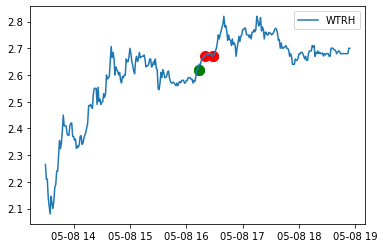

MRAM analysis for run 549 with profit 49.14


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2167.12,-2167.12,buy,2020-05-08 17:31:18.397305,5.26,"[4.7841, 4.8003, 4.8741, 4.885, 4.901, 4.92, 4.97, 5.07]","[5.325, 5.36, 5.5666]",412,"{'avg': 5.1067, 'rsi': 65.42648542340702, 'macd': [0.04910935092756219, 0.05069770129570195, 0.04976894216765437, 0.051664997640920696, 0.05734806107278523], 'vwap': 5.2548, 'supports': [4.7841, 4.8003, 4.8741, 4.885, 4.901, 4.92, 4.97, 5.07], 'sell_macd': [0.02955023693624792, 0.03046155353473523, 0.02973710473440505, 0.030864325088245437, 0.03445872633684566], 'slow macd': [0.025550497429589036, 0.0270623096649123, 0.02809007084636761, 0.029630461967976807, 0.03195989744296668], 'macd_signal': [0.04988071091986261, 0.05004410899503048, 0.049989075629555256, 0.05032426003182834, 0.05172902024001972], 'resistances': [5.5666], 'position_ratio': '1.61', 'sell_macd_signal': [0.030696660665607563, 0.030649639239433098, 0.03046713233842749, 0.030546570888391078, 0.03132900197808199]}",5.95,5.03
1,-1060.90,1106.22,sell,2020-05-08 17:32:11.049458,5.37,None,None,206,"{'avg': 5.1095, 'rsi': [69.28076066534003, 71.37340495916595], 'vwap': 5.351, 'reasons': 'scale-out', 'movement': 0.02091254752851717, 'sell_macd': [0.02973710473440505, 0.030864325088245437, 0.03759119386931342, 0.042848608583530456, 0.04846674201560219], 'sell_macd_signal': [0.03046713233842749, 0.030546570888391078, 0.03195549548457555, 0.03413411810436653, 0.03700064288661366]}",5.95,5.03
2,-496.46,564.44,sell,2020-05-08 17:32:32.679656,5.48,None,None,103,"{'avg': 5.1122, 'rsi': [69.28076066534003, 76.06171061377864], 'vwap': 5.4887, 'reasons': 'scale-out', 'movement': 0.021415270018622014, 'sell_macd': [0.02973710473440505, 0.030864325088245437, 0.03759119386931342, 0.042848608583530456, 0.054440767989627936], 'sell_macd_signal': [0.03046713233842749, 0.030546570888391078, 0.03195549548457555, 0.03413411810436653, 0.03819544808141881]}",5.95,5.03
3,-210.86,285.60,sell,2020-05-08 17:49:42.424336,5.60,None,None,51,"{'avg': 5.1426, 'rsi': [64.70592626495893, 68.82069758881403], 'vwap': 5.5557, 'reasons': 'scale-out', 'movement': 0.020072992700729823, 'sell_macd': [0.035195720956394894, 0.038334299240288416, 0.04474962908176039, 0.04734924156756026, 0.05317557283483776], 'sell_macd_signal': [0.03985232770365832, 0.03954872201098434, 0.04058890342513955, 0.041940971053623696, 0.04418789140986651]}",5.95,5.03
4,49.14,260.00,sell,2020-05-08 17:59:47.295082,5.00,None,None,52,"{'avg': 5.1616, 'rsi': [40.06463403523471, 29.82401093924807], 'vwap': 5.1185, 'reasons': 'stopped', 'movement': -0.10535714285714284, 'sell_macd': [0.0367905664799153, 0.03191015102790562, 0.024061643519484477, 0.011913953986694814, -0.009654556739981501], 'sell_macd_signal': [0.04346923875037319, 0.041157421205879674, 0.03773826566860063, 0.03257340333221947, 0.024127811317779274]}",5.95,5.03


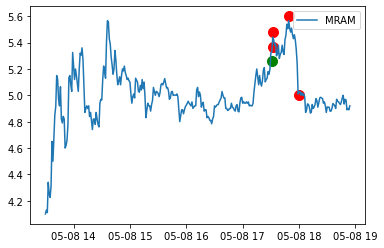

SLB analysis for run 549 with profit -91.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-12194.00,-12194.00,buy,2020-05-08 15:07:29.891761,17.42,"[17.225, 17.325]",[17.42],700,"{'avg': 17.3536, 'rsi': 56.776226462749854, 'macd': [-0.0050484607055913955, -0.003168399115960341, -0.0012604488777476774, 0.0026419104129047355, 0.006466927972102354], 'vwap': 17.425, 'supports': [17.19, 17.225, 17.325, 17.325], 'sell_macd': [-0.0021563023754040955, -0.0009583472645431357, 0.00024731057852633853, 0.002742013955220557, 0.005169808612969007], 'slow macd': [0.019045052677100216, 0.018592846895824522, 0.018227034464675995, 0.018341131808966793, 0.018576706963695955], 'macd_signal': [-0.0125130999072415, -0.010644159748985268, -0.00876741757473775, -0.006485551977209253, -0.003895055987346931], 'resistances': [17.565, 17.5683], 'position_ratio': '1.4', 'sell_macd_signal': [-0.007226253212941645, -0.005972672023261944, -0.0047286755029042876, -0.003234537611279319, -0.0015536683664296538]}",17.83,17.29
1,-91.00,12103.00,sell,2020-05-08 15:37:02.804604,17.29,None,None,700,"{'avg': 17.3575, 'rsi': [44.26424290084213, 36.63806537544576], 'vwap': 17.29, 'reasons': 'stopped', 'movement': -0.0074626865671643255, 'sell_macd': [0.0021904789368925037, 0.0049188712179635274, 0.004383607135448386, 0.0018316661992621164, -0.003297530195158771], 'sell_macd_signal': [-0.0015354293906342828, -0.0002445692689147206, 0.0006810660119579007, 0.0009111860494187439, 6.94428005032408e-05]}",17.83,17.29
2,-14154.35,-14063.35,buy,2020-05-08 17:17:26.296847,17.47,"[17.2, 17.29, 17.31, 17.37, 17.395]","[17.565, 17.5683]",805,"{'avg': 17.3553, 'rsi': 67.69736360796851, 'macd': [0.007062967958134436, 0.009544353689602048, 0.01217741255397442, 0.012904995281857623, 0.015138799467159458], 'vwap': 17.4697, 'supports': [17.2, 17.29, 17.31, 17.335, 17.37, 17.395], 'sell_macd': [0.003690877404441295, 0.005334595135522591, 0.007065614209928128, 0.007543478239206536, 0.008997093349822904], 'slow macd': [0.012518447449707537, 0.01297559499208134, 0.013535368728600616, 0.013788826502619145, 0.014363017239126918], 'macd_signal': [0.006694496692579587, 0.007264468091984079, 0.008247056984382148, 0.009178644643877243, 0.010370675608533686], 'resistances': [17.5683], 'position_ratio': '1.1', 'sell_macd_signal': [0.0033281715027330206, 0.0037294562292909347, 0.004396687825418373, 0.005026045908176006, 0.005820255396505386]}",17.83,17.36
3,-91.00,14063.35,sell,2020-05-08 17:28:58.753324,17.47,None,None,805,"{'avg': 17.36, 'rsi': [50.89778556168141, 57.40108429521901], 'vwap': 17.4742, 'reasons': 'bail', 'movement': 0.0002862049227248173, 'sell_macd': [0.011307914473999148, 0.01095848329758553, 0.010284141039374362, 0.008586158227267049, 0.008190507227869404], 'sell_macd_signal': [0.009855193143830524, 0.010075851174581525, 0.010117509147540091, 0.009811238963485482, 0.009487092616362266]}",17.83,17.36


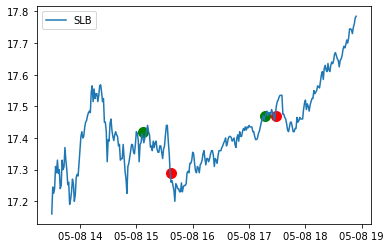

TME analysis for run 549 with profit -88.34


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1212.20,-1212.20,buy,2020-05-08 16:37:58.141047,11.02,"[10.94, 10.965]",[11.0884],110,"{'avg': 10.9252, 'rsi': 64.40693823751675, 'macd': [0.0013264450290311203, 0.002919690062148206, 0.005730127736956803, 0.007866736995149282, 0.009849929582106398], 'vwap': 11.0227, 'supports': [10.9, 10.94, 10.94, 10.965, 10.99], 'sell_macd': [0.0014722113545939663, 0.0024669879675531803, 0.004249060809241811, 0.005582506389657738, 0.006808795070636364], 'slow macd': [-0.0018133524133876477, -0.0014478333746250627, -0.0007893565086956045, -0.00018227426377848133, 0.0004565203554172115], 'macd_signal': [-0.0026967218263654093, -0.0015734394486626863, -0.00011272601153878843, 0.0014831665897988256, 0.0031565191882603405], 'resistances': [11.0884], 'position_ratio': '1.81', 'sell_macd_signal': [-0.0010634773119353727, -0.0003573842560376621, 0.0005639047570182327, 0.0015676250835461338, 0.0026158590809641797]}",11.25,10.95
1,-4319.84,-3107.64,buy,2020-05-08 16:37:58.499248,11.02,"[10.94, 10.965]",[11.0884],282,"{'avg': 10.9252, 'rsi': 64.40693823751675, 'macd': [0.0013264450290311203, 0.002919690062148206, 0.005730127736956803, 0.007866736995149282, 0.009849929582106398], 'vwap': 11.0227, 'supports': [10.9, 10.94, 10.94, 10.965, 10.99], 'sell_macd': [0.0014722113545939663, 0.0024669879675531803, 0.004249060809241811, 0.005582506389657738, 0.006808795070636364], 'slow macd': [-0.0018133524133876477, -0.0014478333746250627, -0.0007893565086956045, -0.00018227426377848133, 0.0004565203554172115], 'macd_signal': [-0.0026967218263654093, -0.0015734394486626863, -0.00011272601153878843, 0.0014831665897988256, 0.0031565191882603405], 'resistances': [11.0884], 'position_ratio': '1.81', 'sell_macd_signal': [-0.0010634773119353727, -0.0003573842560376621, 0.0005639047570182327, 0.0015676250835461338, 0.0026158590809641797]}",11.25,10.95
2,-13907.24,-9587.40,buy,2020-05-08 16:37:58.532049,11.02,"[10.94, 10.965]",[11.0884],870,"{'avg': 10.9252, 'rsi': 64.40693823751675, 'macd': [0.0013264450290311203, 0.002919690062148206, 0.005730127736956803, 0.007866736995149282, 0.009849929582106398], 'vwap': 11.0227, 'supports': [10.9, 10.94, 10.94, 10.965, 10.99], 'sell_macd': [0.0014722113545939663, 0.0024669879675531803, 0.004249060809241811, 0.005582506389657738, 0.006808795070636364], 'slow macd': [-0.0018133524133876477, -0.0014478333746250627, -0.0007893565086956045, -0.00018227426377848133, 0.0004565203554172115], 'macd_signal': [-0.0026967218263654093, -0.0015734394486626863, -0.00011272601153878843, 0.0014831665897988256, 0.0031565191882603405], 'resistances': [11.0884], 'position_ratio': '1.81', 'sell_macd_signal': [-0.0010634773119353727, -0.0003573842560376621, 0.0005639047570182327, 0.0015676250835461338, 0.0026158590809641797]}",11.25,10.95
3,-88.34,13818.90,sell,2020-05-08 17:47:25.081802,10.95,None,None,1262,"{'avg': 10.9323, 'rsi': [36.228649637078455, 29.686452254587802], 'vwap': 10.95, 'reasons': 'stopped', 'movement': -0.006352087114337594, 'sell_macd': [-0.004414582256442756, -0.004471312760511381, -0.004457449351207288, -0.004388757741994098, -0.004797715478424891], 'sell_macd_signal': [-0.0035936521823357655, -0.0037691842979708885, -0.003906837308618168, -0.004003221395293354, -0.0041621202119196616]}",11.25,10.95


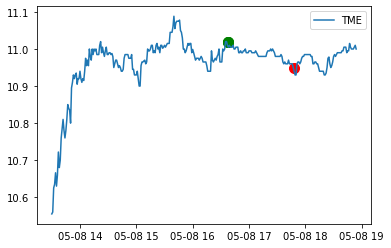

WY analysis for run 549 with profit -49.61


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-15307.15,-15307.15,buy,2020-05-08 15:10:11.283636,19.45,"[19.3, 19.345]","[19.54, 19.585]",787,"{'avg': 19.3606, 'rsi': 59.88412835707608, 'macd': [-0.009799001011998598, -0.004943371574825051, -0.000285047980742803, 0.0037667445557083568, 0.007297160422666593], 'vwap': 19.4456, 'supports': [18.63, 19.09, 19.3, 19.345, 19.44], 'sell_macd': [-0.005574441741089231, -0.0024039191847080588, 0.000617318121360455, 0.0032232521504909073, 0.0054717299374686945], 'slow macd': [0.02086110551572773, 0.020799698936226463, 0.02086987273263574, 0.020981024437794815, 0.021129699358159115], 'macd_signal': [-0.012107834017698129, -0.010674941529123513, -0.00859696281944737, -0.006124221344416226, -0.0034399449909996616], 'resistances': [19.54, 19.585], 'position_ratio': '9.0', 'sell_macd_signal': [-0.007236246767962991, -0.0062697812513120045, -0.004892361376777512, -0.003269238671323828, -0.0015210449495653235]}",19.81,19.33
1,39.35,15346.50,sell,2020-05-08 15:33:46.650452,19.50,None,None,787,"{'avg': 19.3758, 'rsi': [63.90500362225316, 56.81145940816138], 'vwap': 19.5101, 'reasons': 'bail', 'movement': 0.0030848329048844356, 'sell_macd': [0.021061114001085457, 0.02078187361970052, 0.02003464898979601, 0.019711686304290765, 0.01790532984409765], 'sell_macd_signal': [0.01618347265192014, 0.017103152845476217, 0.017689452074340174, 0.018093898920330292, 0.018056185105083764]}",19.81,19.33
2,-21577.93,-21617.28,buy,2020-05-08 16:18:41.199603,19.44,"[19.375, 19.38]","[19.44, 19.455]",1112,"{'avg': 19.3823, 'rsi': 58.402350658120895, 'macd': [0.0029418709672377474, 0.0029259424099059572, 0.0032789790967875376, 0.003518207508481197, 0.0052609852383440625], 'vwap': 19.445, 'supports': [19.3, 19.345, 19.375, 19.375, 19.38, 19.4, 19.44], 'sell_macd': [0.0024633849066724167, 0.0024078676748402472, 0.0025930767451676218, 0.0027037191799017535, 0.0037937818669675494], 'slow macd': [0.0003472673249476088, 0.00038671383224908595, 0.0005023553988117158, 0.0006079458918399894, 0.0010239922496566578], 'macd_signal': [-0.0019092699851099909, -0.0009422275061068012, -9.79861855279335e-05, 0.0006252525532738927, 0.0015523990902879268], 'resistances': [19.455, 19.47, 19.55, 19.585], 'position_ratio': '2.0', 'sell_macd_signal': [-0.0006271024836535854, -2.0108451954818857e-05, 0.0005025285874696693, 0.0009427667059560862, 0.001512969738158379]}",19.70,19.36
3,-49.61,21528.32,sell,2020-05-08 16:24:09.939515,19.36,None,None,1112,"{'avg': 19.3831, 'rsi': [39.45202458471204, 35.10395844562405], 'vwap': 19.3602, 'reasons': 'stopped', 'movement': -0.0041152263374486546, 'sell_macd': [0.0030629395645185298, 0.002120295519116411, 0.0005790106068666034, -0.001408731020948295, -0.003978286431959077], 'sell_macd_signal': [0.002149680614132011, 0.002143803595128891, 0.0018308449974764336, 0.0011829297937914877, 0.00015068654864137465]}",19.70,19.36


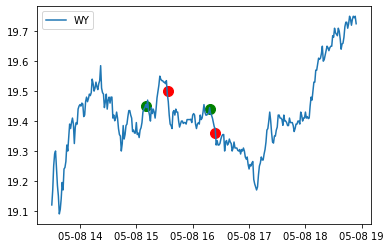

LB analysis for run 549 with profit 156.12


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-8712.00,-8712.00,buy,2020-05-08 16:05:24.874981,12.00,[11.885],[12.115],726,"{'avg': 11.8739, 'rsi': 62.40240978526715, 'macd': [0.0030619768774364786, 0.0062484409119285544, 0.009471471811751897, 0.012287561869314345, 0.015550452234990075], 'vwap': 12.0, 'supports': [11.82, 11.83, 11.84, 11.885], 'sell_macd': [0.0025464035236879567, 0.004586930875799311, 0.006636862177758829, 0.008407758488667483, 0.010457706802508682], 'slow macd': [0.00518521777504688, 0.0057257177011180715, 0.006373773462447829, 0.007039779545202407, 0.007881171339779058], 'macd_signal': [-0.005535860055671556, -0.003178999862151534, -0.0006489055273708475, 0.001938387951966191, 0.0046608008085709685], 'resistances': [12.115], 'position_ratio': '1.0', 'sell_macd_signal': [-0.0031156142553246044, -0.0015751052290998212, 6.728825227190886e-05, 0.0017353822995510237, 0.0034798472001425556]}",12.39,11.87
1,50.82,8762.82,sell,2020-05-08 16:23:42.827165,12.07,None,None,726,"{'avg': 11.8922, 'rsi': [64.10837116640164, 59.744107176447784], 'vwap': 12.075, 'reasons': 'bail', 'movement': 0.0062499999999999405, 'sell_macd': [0.02186031513545217, 0.022496139464010412, 0.02334877998673157, 0.022541113121492984, 0.020839799809337478], 'sell_macd_signal': [0.019974352389301446, 0.02047870980424324, 0.021052723840740906, 0.02135040169689132, 0.02124828131938055]}",12.39,11.87
2,-8597.82,-8648.64,buy,2020-05-08 17:21:43.896838,12.32,"[11.885, 12.23, 12.25]",[12.42],702,"{'avg': 12.0128, 'rsi': 58.869886543750106, 'macd': [0.0010543906953017768, -0.0010828993094484929, 4.6949254457473444e-05, 0.0013304836078944504, 0.005112962276736965], 'vwap': 12.325, 'supports': [11.83, 11.885, 12.23, 12.25], 'sell_macd': [-0.0003249692164875029, -0.001623901321211818, -0.0007967847622794011, 0.00011780976107544916, 0.0026471326395185457], 'slow macd': [0.03099101120104919, 0.029784952568581602, 0.029187479268468763, 0.028671071439346107, 0.02870988043552103], 'macd_signal': [-0.003156268107587676, -0.0027415943479598393, -0.002183885627476377, -0.0014810117804022113, -0.00016221696897437596], 'resistances': [12.42], 'position_ratio': '1.27', 'sell_macd_signal': [-0.0037196620962699615, -0.0033005099412583326, -0.0027997649054625462, -0.0022162499721549473, -0.0012435734498202487]}",12.73,12.19
3,156.12,8753.94,sell,2020-05-08 18:06:34.665043,12.47,None,None,702,"{'avg': 12.0482, 'rsi': [77.47003718783849, 79.14925378236363], 'vwap': 12.473, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.012987012987012998, 'sell_macd': [0.01723029143550825, 0.019430164933138983, 0.020632272010082886, 0.022859468797181037, 0.02507729137417769], 'sell_macd_signal': [0.010969584670515835, 0.012661700723040464, 0.014255814980448948, 0.015976545743795367, 0.017796694869871833]}",12.73,12.19


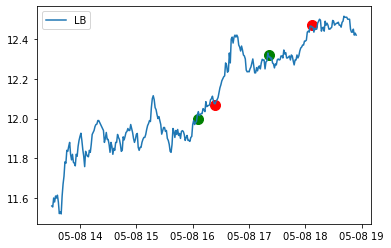

AMX analysis for run 549 with profit -105.8


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-9801.64,-9801.64,buy,2020-05-08 15:25:22.683513,12.68,"[12.6, 12.61, 12.65]","[12.72, 12.82]",773,"{'avg': 12.671, 'rsi': 65.31688384750987, 'macd': [-0.004877367077524397, -0.0028710191319358813, 0.0003290656588479379, 0.0028325045614980837, 0.00555932986059382], 'vwap': 12.6695, 'supports': [12.6, 12.61, 12.65], 'sell_macd': [-0.0025667788674432757, -0.0012643359688553346, 0.0008059355880796204, 0.002408667507925344, 0.004145748646662284], 'slow macd': [0.011051496197215016, 0.010899258652498744, 0.01106163545177985, 0.011193335760989243, 0.011456538107431413], 'macd_signal': [-0.008423355876989422, -0.007312888527978715, -0.005784497690613384, -0.004061097240191091, -0.0021370118200341086], 'resistances': [12.72, 12.87], 'position_ratio': '1.33', 'sell_macd_signal': [-0.004981542287425393, -0.004238101023711381, -0.0032292937013531807, -0.0021017014594974757, -0.0008522114382655238]}",12.95,12.59
1,-13415.44,-3613.80,buy,2020-05-08 15:25:22.728276,12.68,"[12.6, 12.61, 12.65]","[12.72, 12.82]",285,"{'avg': 12.671, 'rsi': 65.31688384750987, 'macd': [-0.004877367077524397, -0.0028710191319358813, 0.0003290656588479379, 0.0028325045614980837, 0.00555932986059382], 'vwap': 12.6695, 'supports': [12.6, 12.61, 12.65], 'sell_macd': [-0.0025667788674432757, -0.0012643359688553346, 0.0008059355880796204, 0.002408667507925344, 0.004145748646662284], 'slow macd': [0.011051496197215016, 0.010899258652498744, 0.01106163545177985, 0.011193335760989243, 0.011456538107431413], 'macd_signal': [-0.008423355876989422, -0.007312888527978715, -0.005784497690613384, -0.004061097240191091, -0.0021370118200341086], 'resistances': [12.72, 12.87], 'position_ratio': '1.33', 'sell_macd_signal': [-0.004981542287425393, -0.004238101023711381, -0.0032292937013531807, -0.0021017014594974757, -0.0008522114382655238]}",12.95,12.59
2,-4923.94,8491.50,sell,2020-05-08 16:18:45.806998,12.58,None,None,675,"{'avg': 12.6669, 'rsi': [32.0521218980307, 25.677780339629802], 'vwap': 12.5966, 'reasons': 'stopped', 'movement': -0.007492113564668681, 'sell_macd': [-0.0059922831667407195, -0.0061137619112265895, -0.006388761427563949, -0.006520075837338268, -0.007316943223690586], 'sell_macd_signal': [-0.003911498158570699, -0.004351950909101877, -0.004759313012794292, -0.0051114655777030876, -0.0055525611069005875]}",12.95,12.59
3,-105.80,4818.14,sell,2020-05-08 16:18:45.892622,12.58,None,None,383,"{'avg': 12.6669, 'rsi': [32.0521218980307, 25.677780339629802], 'vwap': 12.5966, 'reasons': 'stopped', 'movement': -0.007492113564668681, 'sell_macd': [-0.0059922831667407195, -0.0061137619112265895, -0.006388761427563949, -0.006520075837338268, -0.007316943223690586], 'sell_macd_signal': [-0.003911498158570699, -0.004351950909101877, -0.004759313012794292, -0.0051114655777030876, -0.0055525611069005875]}",12.95,12.59


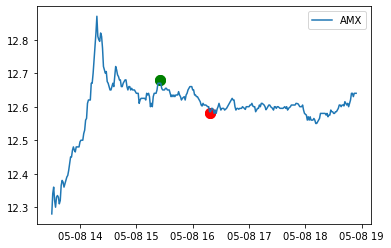

NBL analysis for run 549 with profit 5.29


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5147.17,-5147.17,buy,2020-05-08 15:30:15.281769,9.73,"[9.5308, 9.58, 9.635]",[9.9],529,"{'avg': 9.5726, 'rsi': 65.51317865217717, 'macd': [-0.01452559506282114, -0.01260078715084667, -0.009353706454559685, -0.002714498428073142, 0.005708977928042813], 'vwap': 9.722, 'supports': [9.145, 9.5308, 9.58, 9.58, 9.635], 'sell_macd': [-0.008969862698782194, -0.007670851882844332, -0.005520053170648964, -0.0011750145225661868, 0.004303911885322975], 'slow macd': [0.009864403669542554, 0.00938168534907291, 0.009242436409930832, 0.009899221074221032, 0.011127395655684325], 'macd_signal': [-0.012510404064427634, -0.012528480681711442, -0.011893525836281092, -0.010057720354639501, -0.006904380698103038], 'resistances': [9.9], 'position_ratio': '1.79', 'sell_macd_signal': [-0.007799970996695375, -0.007774147173925166, -0.007323328373269926, -0.006093665603129178, -0.004014150105438747]}",10.27,9.55
1,5.29,5152.46,sell,2020-05-08 15:42:08.856946,9.74,None,None,529,"{'avg': 9.5856, 'rsi': [58.63560697276036, 59.51694859951869], 'vwap': 9.745, 'reasons': 'bail', 'movement': 0.001541623843781993, 'sell_macd': [0.01977837706467689, 0.019613271005397337, 0.018970158868226505, 0.017962926568248605, 0.017204525729715314], 'sell_macd_signal': [0.016140661774412306, 0.01683518362060931, 0.01726217867013275, 0.017402328249755922, 0.0173627677457478]}",10.27,9.55
2,-9715.86,-9721.15,buy,2020-05-08 15:54:34.069105,9.77,[9.69],[9.785],995,"{'avg': 9.5915, 'rsi': 62.67308238358675, 'macd': [0.010423939763279932, 0.00979366356857092, 0.009196225939456681, 0.012213091319045688, 0.015235272555829127], 'vwap': 9.7706, 'supports': [9.5308, 9.58, 9.58, 9.635, 9.69, 9.765], 'sell_macd': [0.005566043615445437, 0.005166621191616372, 0.004793478767961545, 0.006778127804491163, 0.008756060458871673], 'slow macd': [0.018232399789599896, 0.018020373913760324, 0.017798081616295036, 0.018284812162903563, 0.018863311858662968], 'macd_signal': [0.01541709497962893, 0.014292408697417328, 0.013273172145825199, 0.013061155980469297, 0.013495979295541263], 'resistances': [9.785, 9.9], 'position_ratio': '1.0', 'sell_macd_signal': [0.008965650274228076, 0.008205844457705735, 0.007523371319756897, 0.0073743226167037506, 0.007650670185137335]}",10.06,9.68
3,5.29,9721.15,sell,2020-05-08 16:10:45.800913,9.77,None,None,995,"{'avg': 9.5999, 'rsi': [53.67349680282415, 55.79704942489337], 'vwap': 9.7705, 'reasons': 'bail', 'movement': 0.000511770726714512, 'sell_macd': [0.011562682283056347, 0.010162746631422692, 0.008420423440130165, 0.007732633636004849, 0.007615750234920782], 'sell_macd_signal': [0.009898948488599641, 0.00995170811716425, 0.009645451181757433, 0.009262887672606916, 0.00893346018506969]}",10.06,9.68


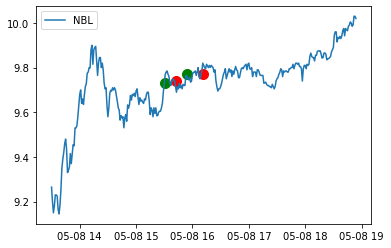

MUR analysis for run 549 with profit 60.55


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-9878.30,-9878.30,buy,2020-05-08 15:25:26.757162,11.42,"[11.2, 11.33]","[11.55, 11.8371]",865,"{'avg': 11.1568, 'rsi': 68.64193663678435, 'macd': [0.021136269920591033, 0.020714644383856395, 0.021025739540160515, 0.022625307089512603, 0.025216132866475505], 'vwap': 11.4109, 'supports': [10.97, 11.15, 11.2, 11.33], 'sell_macd': [0.012389020570568121, 0.012085142099202528, 0.012262832353993502, 0.013280995768713666, 0.0149408504325379], 'slow macd': [0.03532881048044345, 0.03505289000694489, 0.03491890177441803, 0.03505965246208653, 0.03545294663340748], 'macd_signal': [0.02186719314414296, 0.02163668339208565, 0.021514494621700624, 0.02173665711526302, 0.02243255226550552], 'resistances': [11.55], 'position_ratio': '1.44', 'sell_macd_signal': [0.013066586390304996, 0.012870297532084502, 0.012748804496466303, 0.012855242750915775, 0.0132723642872402]}",11.75,11.31
1,60.55,9938.85,sell,2020-05-08 15:32:45.062610,11.49,None,None,865,"{'avg': 11.1704, 'rsi': [78.06967214670992, 79.64994387934665], 'vwap': 11.5014, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.007443082311733875, 'sell_macd': [0.016100923605675277, 0.017099710838190063, 0.019500068281212535, 0.022156190077316396, 0.024717373423925437], 'sell_macd_signal': [0.01436211270813142, 0.014909632334143148, 0.015827719523557025, 0.0170934136343089, 0.018618205592232207]}",11.75,11.31
2,-13461.14,-13521.69,buy,2020-05-08 16:01:58.611038,11.43,"[11.33, 11.36]",[11.51],1183,"{'avg': 11.1931, 'rsi': 62.477190284484465, 'macd': [-0.004484251921432758, -0.0034194555848898744, -0.001349664089479674, 0.0014839294079429521, 0.005282512012387386], 'vwap': 11.43, 'supports': [11.15, 11.2, 11.33, 11.33, 11.36], 'sell_macd': [-0.0032972220947300457, -0.002544484651190615, -0.001145669959456086, 0.0007384151244860249, 0.003235904603863915], 'slow macd': [0.017598271354094308, 0.01716036699947132, 0.01696993941531133, 0.017007502938376717, 0.017334733508075573], 'macd_signal': [-0.0039018076702423553, -0.003805337253171859, -0.003314202620433422, -0.002354576214758147, -0.0008271585693290404], 'resistances': [11.51], 'position_ratio': '1.14', 'sell_macd_signal': [-0.0032418920400476723, -0.003102410562276261, -0.002711062441712226, -0.0020211669284725758, -0.0009697526220052775]}",11.67,11.34
3,60.55,13521.69,sell,2020-05-08 16:18:07.635935,11.43,None,None,1183,"{'avg': 11.2059, 'rsi': [52.40701199725629, 53.592337512470266], 'vwap': 11.44, 'reasons': 'bail', 'movement': 0.0008748906386701476, 'sell_macd': [0.014653722602849584, 0.015419532729756824, 0.014777053182804423, 0.012785808689299571, 0.011327880399692347], 'sell_macd_signal': [0.009647028656355526, 0.010801529471035786, 0.011596634213389512, 0.011834469108571524, 0.011733151366795688]}",11.67,11.34


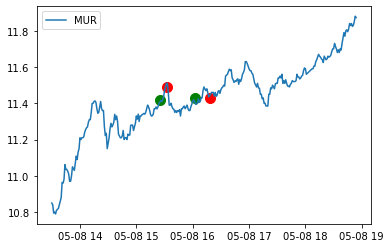

AGRX analysis for run 549 with profit 0.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2038.01,-2038.01,buy,2020-05-08 15:10:13.254775,2.57,"[2.5109, 2.5199, 2.5301, 2.5395]",[2.57],793,"{'avg': 2.5534, 'rsi': 61.918887134879206, 'macd': [0.002527607678129762, 0.0032375307694079147, 0.004155703780871711, 0.004827711652749311, 0.006096917687380188], 'vwap': 2.5604, 'supports': [2.5109, 2.5199, 2.5301, 2.5395, 2.549, 2.57], 'sell_macd': [0.0021221821746970626, 0.0025473785550200745, 0.0031053578311803776, 0.0034998175550562394, 0.0042812171119068765], 'slow macd': [0.00038918495349804516, 0.0005695072471834095, 0.0008144666909180032, 0.0010385345890671083, 0.0014029592573132632], 'macd_signal': [-0.002210281410471038, -0.0011207189744952474, -6.54344234218558e-05, 0.0009131947918123778, 0.0019499393709259398], 'resistances': [2.57, 2.59, 2.59, 2.64, 2.64], 'position_ratio': 'nan', 'sell_macd_signal': [-0.0009316346056291155, -0.00023583197349927743, 0.00043240598743665357, 0.0010458883009605707, 0.001692954063149832]}",2.78,2.5
1,-3479.78,-1441.77,buy,2020-05-08 15:10:13.334084,2.57,"[2.5109, 2.5199, 2.5301, 2.5395]",[2.57],561,"{'avg': 2.5534, 'rsi': 61.918887134879206, 'macd': [0.002527607678129762, 0.0032375307694079147, 0.004155703780871711, 0.004827711652749311, 0.006096917687380188], 'vwap': 2.5604, 'supports': [2.5109, 2.5199, 2.5301, 2.5395, 2.549, 2.57], 'sell_macd': [0.0021221821746970626, 0.0025473785550200745, 0.0031053578311803776, 0.0034998175550562394, 0.0042812171119068765], 'slow macd': [0.00038918495349804516, 0.0005695072471834095, 0.0008144666909180032, 0.0010385345890671083, 0.0014029592573132632], 'macd_signal': [-0.002210281410471038, -0.0011207189744952474, -6.54344234218558e-05, 0.0009131947918123778, 0.0019499393709259398], 'resistances': [2.57, 2.59, 2.59, 2.64, 2.64], 'position_ratio': 'nan', 'sell_macd_signal': [-0.0009316346056291155, -0.00023583197349927743, 0.00043240598743665357, 0.0010458883009605707, 0.001692954063149832]}",2.78,2.5
2,0.00,3479.78,sell,2020-05-08 15:22:07.175591,2.57,None,None,1354,"{'avg': 2.5542, 'rsi': [60.61876695530914, 60.61876695530914], 'vwap': 2.5775, 'reasons': 'bail', 'movement': 0.003891050583657678, 'sell_macd': [0.006129187745287368, 0.005621026882934199, 0.0056715375501532606, 0.005637240179802827, 0.005537304044727076], 'sell_macd_signal': [0.00561514517377814, 0.005616321515609352, 0.005627364722518133, 0.005629339813975072, 0.005610932660125472]}",2.78,2.5


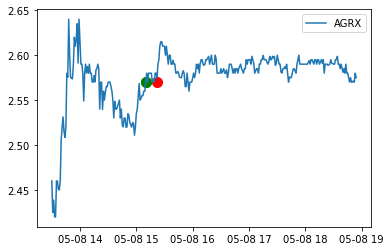

CWH analysis for run 549 with profit 3.93


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1302.00,-1302.00,buy,2020-05-08 15:05:28.401559,14.00,"[13.4, 13.69]","[14.08, 14.11, 14.5592]",93,"{'avg': 13.7523, 'rsi': 62.27788769875603, 'macd': [-0.020826627022042743, -0.012080848937559452, -0.001900186917662694, 0.013277256965931628, 0.027960698675689954], 'vwap': 14.0082, 'supports': [13.4, 13.69, 13.88, 13.9899], 'sell_macd': [-0.010320527932627499, -0.004686689061381699, 0.0018421034235043265, 0.01158087544518871, 0.020936011105654018], 'slow macd': [0.07804490841948208, 0.07648367176142123, 0.07556470325392439, 0.07603779187896897, 0.07694160065894096], 'macd_signal': [-0.03495189078937275, -0.030377682419010087, -0.024682183318740607, -0.01709029526180616, -0.008080096474306936], 'resistances': [14.08, 14.11, 14.5592], 'position_ratio': '4.3', 'sell_macd_signal': [-0.019953014588854796, -0.016899749483360177, -0.013151378901987277, -0.00820492803255208, -0.0023767402049108596]}",16.16,13.29
1,-1834.00,-532.00,buy,2020-05-08 15:05:28.700288,14.00,"[13.4, 13.69]","[14.08, 14.11, 14.5592]",38,"{'avg': 13.7523, 'rsi': 62.27788769875603, 'macd': [-0.020826627022042743, -0.012080848937559452, -0.001900186917662694, 0.013277256965931628, 0.027960698675689954], 'vwap': 14.0082, 'supports': [13.4, 13.69, 13.88, 13.9899], 'sell_macd': [-0.010320527932627499, -0.004686689061381699, 0.0018421034235043265, 0.01158087544518871, 0.020936011105654018], 'slow macd': [0.07804490841948208, 0.07648367176142123, 0.07556470325392439, 0.07603779187896897, 0.07694160065894096], 'macd_signal': [-0.03495189078937275, -0.030377682419010087, -0.024682183318740607, -0.01709029526180616, -0.008080096474306936], 'resistances': [14.08, 14.11, 14.5592], 'position_ratio': '4.3', 'sell_macd_signal': [-0.019953014588854796, -0.016899749483360177, -0.013151378901987277, -0.00820492803255208, -0.0023767402049108596]}",16.16,13.29
2,3.93,1837.93,sell,2020-05-08 15:20:05.821544,14.03,None,None,131,"{'avg': 13.7704, 'rsi': [58.36941714361535, 58.36941714361535], 'vwap': 14.04, 'reasons': 'bail', 'movement': 0.0028571428571427964, 'sell_macd': [0.04316221814211829, 0.04312302326973949, 0.04149348150853882, 0.03916535180489511, 0.03684258383056438], 'sell_macd_signal': [0.036401730038675265, 0.03774598868488811, 0.03849548724961825, 0.038629460160673625, 0.038272084894651774]}",16.16,13.29


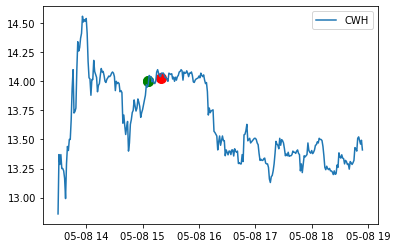

IGT analysis for run 549 with profit 42.9


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3070.90,-3070.90,buy,2020-05-08 15:09:48.913528,7.49,"[7.285, 7.38]",[7.495],410,"{'avg': 7.4423, 'rsi': 60.0726590843896, 'macd': [-0.013063666790698925, -0.008947689464508635, -0.004823232135276356, 0.00045744790483759346, 0.005387240552734873], 'vwap': 7.49, 'supports': [7.27, 7.285, 7.38, 7.47], 'sell_macd': [-0.006667955095090328, -0.004012689555730198, -0.0013720581022580447, 0.0020020970316458886, 0.00512478808362804], 'slow macd': [-0.000865721734699676, -0.0006331140843052196, -0.0002581590023797986, 0.00048706461997838346, 0.0013318512239637315], 'macd_signal': [-0.023576240414087252, -0.02065053022417153, -0.017485070606392494, -0.013896566904146476, -0.010039805412770206], 'resistances': [7.555, 7.63], 'position_ratio': '3.25', 'sell_macd_signal': [-0.013735112495388835, -0.011790627907457107, -0.009706913946417295, -0.007365111750804658, -0.004867131783918118]}",8.15,7.27
1,-3213.21,-142.31,buy,2020-05-08 15:09:48.987772,7.49,"[7.285, 7.38]",[7.495],19,"{'avg': 7.4423, 'rsi': 60.0726590843896, 'macd': [-0.013063666790698925, -0.008947689464508635, -0.004823232135276356, 0.00045744790483759346, 0.005387240552734873], 'vwap': 7.49, 'supports': [7.27, 7.285, 7.38, 7.47], 'sell_macd': [-0.006667955095090328, -0.004012689555730198, -0.0013720581022580447, 0.0020020970316458886, 0.00512478808362804], 'slow macd': [-0.000865721734699676, -0.0006331140843052196, -0.0002581590023797986, 0.00048706461997838346, 0.0013318512239637315], 'macd_signal': [-0.023576240414087252, -0.02065053022417153, -0.017485070606392494, -0.013896566904146476, -0.010039805412770206], 'resistances': [7.555, 7.63], 'position_ratio': '3.25', 'sell_macd_signal': [-0.013735112495388835, -0.011790627907457107, -0.009706913946417295, -0.007365111750804658, -0.004867131783918118]}",8.15,7.27
2,42.90,3256.11,sell,2020-05-08 15:27:43.250940,7.59,None,None,429,"{'avg': 7.4513, 'rsi': [68.56171858202626, 61.02571929276902], 'vwap': 7.5937, 'reasons': 'bail', 'movement': 0.013351134846461901, 'sell_macd': [0.02732817447408209, 0.02756084205118725, 0.027124468188525874, 0.026691911046341055, 0.02470950403884231], 'sell_macd_signal': [0.023015196018768374, 0.02392432522525215, 0.024564353817906896, 0.024989865263593727, 0.024933793018643444]}",8.15,7.27


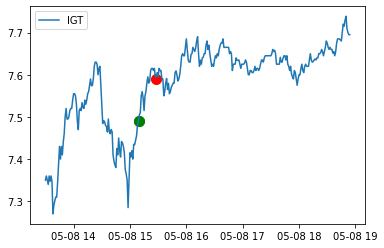

XME analysis for run 549 with profit 7.93


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-14309.91,-14309.91,buy,2020-05-08 15:31:17.170926,20.07,"[19.89, 19.97]",[20.13],713,"{'avg': 19.9374, 'rsi': 65.30994925091304, 'macd': [0.007590211091731192, 0.009602674245943632, 0.013128077865388832, 0.01527786044055901, 0.018383497951699468], 'vwap': 20.07, 'supports': [19.89, 19.91, 19.97, 20.03], 'sell_macd': [0.005186802883656583, 0.006441813256127915, 0.008676343244335527, 0.010003556959247817, 0.011946794179191755], 'slow macd': [0.01722164175032148, 0.017351239853585554, 0.017855358316676728, 0.018197843382772305, 0.01880370774244966], 'macd_signal': [0.004029213605592894, 0.005143905733663042, 0.0067407401600082, 0.008448164216118362, 0.010435230963234583], 'resistances': [20.13], 'position_ratio': '1.5', 'sell_macd_signal': [0.003033820946747374, 0.0037154194086234825, 0.004707604175765891, 0.005766794732462276, 0.007002794621808172]}",20.43,19.95
1,-15915.51,-1605.60,buy,2020-05-08 15:31:17.650828,20.07,"[19.89, 19.97]",[20.13],80,"{'avg': 19.9374, 'rsi': 65.30994925091304, 'macd': [0.007590211091731192, 0.009602674245943632, 0.013128077865388832, 0.01527786044055901, 0.018383497951699468], 'vwap': 20.07, 'supports': [19.89, 19.91, 19.97, 20.03], 'sell_macd': [0.005186802883656583, 0.006441813256127915, 0.008676343244335527, 0.010003556959247817, 0.011946794179191755], 'slow macd': [0.01722164175032148, 0.017351239853585554, 0.017855358316676728, 0.018197843382772305, 0.01880370774244966], 'macd_signal': [0.004029213605592894, 0.005143905733663042, 0.0067407401600082, 0.008448164216118362, 0.010435230963234583], 'resistances': [20.13], 'position_ratio': '1.5', 'sell_macd_signal': [0.003033820946747374, 0.0037154194086234825, 0.004707604175765891, 0.005766794732462276, 0.007002794621808172]}",20.43,19.95
2,7.93,15923.44,sell,2020-05-08 16:06:09.019585,20.08,None,None,793,"{'avg': 19.9531, 'rsi': [53.67949439348813, 55.03924872553806], 'vwap': 20.085, 'reasons': 'bail', 'movement': 0.0007473841554559327, 'sell_macd': [0.011418218673220792, 0.011115127575465067, 0.010474860128184105, 0.009320432764997832, 0.008559574653883573], 'sell_macd_signal': [0.0077097907622472, 0.008390858124890772, 0.008807658525549438, 0.008910213373439117, 0.008840085629528007]}",20.43,19.95


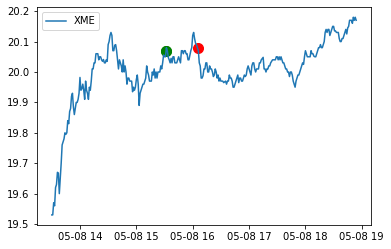

TMST analysis for run 549 with profit 101.99


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4356.43,-4356.43,buy,2020-05-08 15:13:52.499311,2.99,[2.94],[3.14],1457,"{'avg': 2.9647, 'rsi': 56.93746130951711, 'macd': [0.0025434552988761183, 0.00480716785562052, 0.005895749854714971, 0.007311638887000704, 0.007938769736945073], 'vwap': 2.9911, 'supports': [2.47, 2.91, 2.94, 2.96], 'sell_macd': [0.0023401378238232518, 0.0037576659714129157, 0.004403042891983677, 0.005259141234091214, 0.005598190056069985], 'slow macd': [0.009783373911969484, 0.009974780993601495, 0.010008578902782617, 0.01015001619723055, 0.010183941487008852], 'macd_signal': [-0.0014300704746039305, -0.00018262280855904037, 0.001033051724095762, 0.0022887691566767505, 0.003418769272730415], 'resistances': [3.06, 3.06, 3.14], 'position_ratio': '1.86', 'sell_macd_signal': [-9.713530006671544e-05, 0.0006738249542292108, 0.001419668541780104, 0.002187563080242326, 0.0028696884754078576]}",3.19,2.93
1,-2128.75,2227.68,sell,2020-05-08 16:58:35.298548,3.06,None,None,728,"{'avg': 2.9682, 'rsi': [57.460647028999446, 77.07107472787563], 'vwap': 3.0497, 'reasons': 'scale-out', 'movement': 0.02341137123745814, 'sell_macd': [0.0008631653072117551, 0.00122895230302289, 0.0017577609711483255, 0.0021469916090230967, 0.0060587688384186045], 'sell_macd_signal': [0.0006638111604399426, 0.0007768393889565321, 0.0009730237053948909, 0.0012078172861205321, 0.002178007596580147]}",3.19,2.93
2,101.99,2230.74,sell,2020-05-08 16:58:48.665717,3.06,None,None,729,"{'avg': 2.9685, 'rsi': [57.460647028999446, 79.73962625981176], 'vwap': 3.08, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.006535947712418306, 'sell_macd': [0.0008631653072117551, 0.00122895230302289, 0.0017577609711483255, 0.0021469916090230967, 0.007097729877379777], 'sell_macd_signal': [0.0006638111604399426, 0.0007768393889565321, 0.0009730237053948909, 0.0012078172861205321, 0.0023857998043723813]}",3.19,2.93


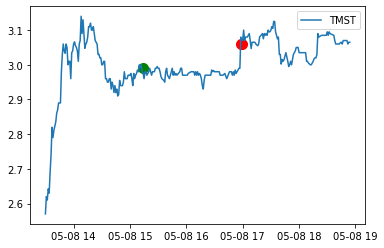

TGI analysis for run 549 with profit 43.62


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4289.30,-4289.30,buy,2020-05-08 15:07:30.073908,5.90,"[5.72, 5.79]",[5.965],727,"{'avg': 5.8273, 'rsi': 63.63952801664187, 'macd': [-3.616730498823273e-05, 0.0011697633109868377, 0.0025001105079933694, 0.006704797223505032, 0.011518101092086397], 'vwap': 5.9, 'supports': [5.55, 5.68, 5.72, 5.79, 5.8, 5.83, 5.9], 'sell_macd': [0.0007940712328640132, 0.0015401256076881253, 0.0023612053074506534, 0.005048264744830888, 0.00811547645259747], 'slow macd': [0.01019757730452664, 0.010075332359099853, 0.01002671702568847, 0.01060569713353221, 0.011441287073401973], 'macd_signal': [-0.006562692732608459, -0.0050162015238894, -0.0035129391175128463, -0.0014693918493092705, 0.0011281067389698634], 'resistances': [5.92, 5.98], 'position_ratio': 'inf', 'sell_macd_signal': [-0.0035188192564087365, -0.002507030283589364, -0.0015333831653813607, -0.00021705358333891085, 0.0014494524238483652]}",6.29,5.77
1,-2525.14,1764.16,sell,2020-05-08 15:23:19.904114,5.96,None,None,296,"{'avg': 5.8439, 'rsi': [65.48911302345739, 62.207257580156124], 'vwap': 5.96, 'reasons': 'bail', 'movement': 0.010169491525423662, 'sell_macd': [0.024633219625143532, 0.02426705434870513, 0.023147093687211573, 0.022498460786214203, 0.021176169424577118], 'sell_macd_signal': [0.01951272559363417, 0.02046359134464836, 0.021000291813161005, 0.021299925607771643, 0.021275174371132737]}",6.29,5.77
2,43.62,2568.76,sell,2020-05-08 15:23:19.956210,5.96,None,None,431,"{'avg': 5.8439, 'rsi': [65.48911302345739, 62.207257580156124], 'vwap': 5.96, 'reasons': 'bail', 'movement': 0.010169491525423662, 'sell_macd': [0.024633219625143532, 0.02426705434870513, 0.023147093687211573, 0.022498460786214203, 0.021176169424577118], 'sell_macd_signal': [0.01951272559363417, 0.02046359134464836, 0.021000291813161005, 0.021299925607771643, 0.021275174371132737]}",6.29,5.77


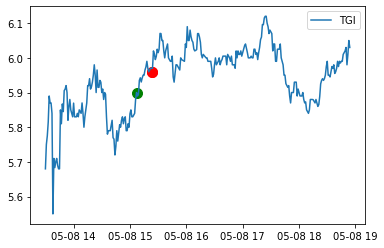

EVRI analysis for run 549 with profit 143.52


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5513.56,-5513.56,buy,2020-05-08 15:08:13.593746,4.61,"[4.51, 4.545]",[4.6999],1196,"{'avg': 4.5343, 'rsi': 59.78792780355248, 'macd': [-0.0016437683757377641, -0.0011274608347271453, 0.0008693893564890587, 0.0024319427614978295, 0.005223892662727714], 'vwap': 4.6017, 'supports': [4.3599, 4.4701, 4.51, 4.54, 4.545], 'sell_macd': [-0.0008146206463353067, -0.0004814945187199271, 0.0008129088861590361, 0.0018161724628678044, 0.003613310672473169], 'slow macd': [0.007482317932429261, 0.007293201476140432, 0.007424217161136504, 0.0075344811445559046, 0.007943749237825593], 'macd_signal': [-0.0030064667306453872, -0.002630665551461739, -0.0019306545698715796, -0.0010581351035976977, 0.00019827044966738488], 'resistances': [4.6999], 'position_ratio': '1.38', 'sell_macd_signal': [-0.0017702913514937985, -0.0015125319849390241, -0.001047443810719412, -0.00047472055600196873, 0.00034288568969305887]}",4.85,4.53
1,-2685.02,2828.54,sell,2020-05-08 15:26:34.660007,4.73,None,None,598,"{'avg': 4.5476, 'rsi': [67.49642042292483, 71.47212334464656], 'vwap': 4.7019, 'reasons': 'scale-out', 'movement': 0.022776572668112696, 'sell_macd': [0.014776323392745816, 0.01452160870451813, 0.01413453740584103, 0.015015591752249868, 0.01673828875266903], 'sell_macd_signal': [0.012786262177986063, 0.013133331483292477, 0.013333572667802187, 0.013669976484691723, 0.014283638938287184]}",4.85,4.53
2,143.52,2828.54,sell,2020-05-08 16:05:05.948120,4.73,None,None,598,"{'avg': 4.5815, 'rsi': [55.05023461278296, 55.050234612782944], 'vwap': 4.74, 'reasons': 'bail', 'movement': 0.002114164904862534, 'sell_macd': [0.01501373672642714, 0.01582698466618382, 0.01424474949370591, 0.012826842223025992, 0.011555397048170768], 'sell_macd_signal': [0.009295248247241344, 0.01060159553102984, 0.011330226323565054, 0.01162954950345724, 0.011614719012399946]}",4.85,4.53


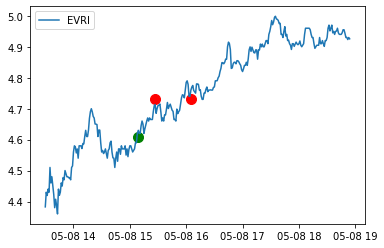

PBYI analysis for run 549 with profit -96.88


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2941.44,-2941.44,buy,2020-05-08 15:30:11.615088,11.49,[11.24],[11.777],256,"{'avg': 11.1487, 'rsi': 59.6281172501374, 'macd': [-0.005300452922815779, -0.004273186751255764, 0.0009678130897246007, 0.007057282331635051, 0.013734133933342108], 'vwap': 11.5, 'supports': [10.04, 10.86, 11.24], 'sell_macd': [0.00043854451801550454, 0.0009234375199902445, 0.0041464263849047, 0.007902697885036503, 0.012020536743774457], 'slow macd': [0.021918246722130164, 0.02096222543544002, 0.020928777261744358, 0.021264371281448646, 0.021937359827715497], 'macd_signal': [-0.029209549049956002, -0.024222276590215953, -0.01918425865422784, -0.013935950457055262, -0.008401933578975788], 'resistances': [11.777, 11.955], 'position_ratio': '1.07', 'sell_macd_signal': [-0.015132217103647655, -0.011921086178920074, -0.008707583666155119, -0.005385527355916794, -0.0019043145359785435]}",12.32,11.22
1,-3975.54,-1034.10,buy,2020-05-08 15:30:11.915772,11.49,[11.24],[11.777],90,"{'avg': 11.1487, 'rsi': 59.6281172501374, 'macd': [-0.005300452922815779, -0.004273186751255764, 0.0009678130897246007, 0.007057282331635051, 0.013734133933342108], 'vwap': 11.5, 'supports': [10.04, 10.86, 11.24], 'sell_macd': [0.00043854451801550454, 0.0009234375199902445, 0.0041464263849047, 0.007902697885036503, 0.012020536743774457], 'slow macd': [0.021918246722130164, 0.02096222543544002, 0.020928777261744358, 0.021264371281448646, 0.021937359827715497], 'macd_signal': [-0.029209549049956002, -0.024222276590215953, -0.01918425865422784, -0.013935950457055262, -0.008401933578975788], 'resistances': [11.777, 11.955], 'position_ratio': '1.07', 'sell_macd_signal': [-0.015132217103647655, -0.011921086178920074, -0.008707583666155119, -0.005385527355916794, -0.0019043145359785435]}",12.32,11.22
2,-96.88,3878.66,sell,2020-05-08 15:43:29.614313,11.21,None,None,346,"{'avg': 11.1568, 'rsi': [33.92724993857287, 30.72774055515584], 'vwap': 11.2247, 'reasons': 'stopped', 'movement': -0.02349869451697124, 'sell_macd': [-0.007097795738520318, -0.010736642945289532, -0.015250853198029546, -0.019609317639149637, -0.024828779312240812], 'sell_macd_signal': [0.00474477163977913, 0.001648488722765397, -0.0017313796613935917, -0.0053069672569448015, -0.009211329668004004]}",12.32,11.22


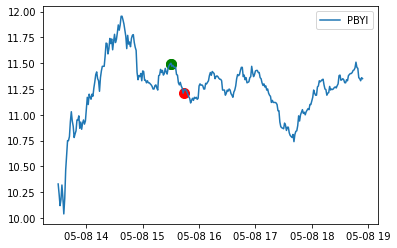

X analysis for run 549 with profit 5.57


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4734.50,-4734.50,buy,2020-05-08 15:19:26.380538,8.50,"[8.365, 8.375]","[8.62, 8.78]",557,"{'avg': 8.3916, 'rsi': 69.81569877328693, 'macd': [0.012104170499970479, 0.013599050738134721, 0.015412999064468025, 0.01825397853308175, 0.020670654999568328], 'vwap': 8.5, 'supports': [8.365, 8.375, 8.41, 8.445], 'sell_macd': [0.008010403331976335, 0.008916600095092875, 0.01002640796122023, 0.011799941260004942, 0.013288409528408707], 'slow macd': [0.011116099726345752, 0.011502233998781364, 0.011999029690457519, 0.012756778897887955, 0.013513497734635393], 'macd_signal': [0.00654065267958584, 0.007952332291295616, 0.009444465645930097, 0.011206368223360427, 0.013099225578602007], 'resistances': [8.78], 'position_ratio': '5.09', 'sell_macd_signal': [0.004536467591332972, 0.005412494092084953, 0.006335276865912008, 0.007428209744730595, 0.008600249701466217]}",9.01,8.33
1,-4019.66,714.84,sell,2020-05-08 15:29:10.840957,8.51,None,None,84,"{'avg': 8.3985, 'rsi': [64.22290343706891, 65.56087023171165], 'vwap': 8.5103, 'reasons': 'bail', 'movement': 0.001764705882353008, 'sell_macd': [0.016956754885567804, 0.01672372692013191, 0.016065215168881153, 0.015343449970908196, 0.01484151020663127], 'sell_macd_signal': [0.01390716450443834, 0.014470476987577054, 0.014789424623837874, 0.01490022969325194, 0.014888485795927806]}",9.01,8.33
2,5.57,4025.23,sell,2020-05-08 15:29:11.013408,8.51,None,None,473,"{'avg': 8.3985, 'rsi': [64.22290343706891, 65.56087023171165], 'vwap': 8.5103, 'reasons': 'bail', 'movement': 0.001764705882353008, 'sell_macd': [0.016956754885567804, 0.01672372692013191, 0.016065215168881153, 0.015343449970908196, 0.01484151020663127], 'sell_macd_signal': [0.01390716450443834, 0.014470476987577054, 0.014789424623837874, 0.01490022969325194, 0.014888485795927806]}",9.01,8.33


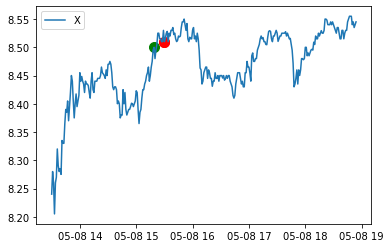

RLJ analysis for run 549 with profit 8.61


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7516.53,-7516.53,buy,2020-05-08 15:12:22.513034,8.73,"[8.57, 8.63]","[8.81, 8.82, 8.87]",861,"{'avg': 8.7239, 'rsi': 64.93524150810798, 'macd': [-0.004458171261457977, -0.0022878646758819343, 0.0014328925028568307, 0.004730546788159984, 0.008855711293305646], 'vwap': 8.73, 'supports': [8.47, 8.57, 8.63, 8.73], 'sell_macd': [-0.001837332046953577, -0.000469842800615794, 0.001900536388745877, 0.0039826430767071486, 0.006592302274121664], 'slow macd': [0.00020550874229918747, 0.0003787340213214918, 0.0009373411508484253, 0.0015297464449055553, 0.002392203700340545], 'macd_signal': [-0.0076240272314393644, -0.006556794720327878, -0.004958857275690937, -0.003020976462920753, -0.000645638911675473], 'resistances': [8.81, 8.82, 8.87], 'position_ratio': 'inf', 'sell_macd_signal': [-0.003766882496569425, -0.0031074745573786986, -0.0021058723681537835, -0.000888169279181597, 0.0006079250314790555]}",9.06,8.62
1,8.61,7525.14,sell,2020-05-08 15:26:51.826349,8.74,None,None,861,"{'avg': 8.7274, 'rsi': [64.33461025755341, 59.008591725015854], 'vwap': 8.7592, 'reasons': 'bail', 'movement': 0.002290950744558943, 'sell_macd': [0.01812735482048211, 0.017774826702874336, 0.017425131718987075, 0.016614653397528656, 0.015143960505517029], 'sell_macd_signal': [0.013303209633989956, 0.014197533047766832, 0.01484305278201088, 0.015197372905114435, 0.015186690425194955]}",9.06,8.62


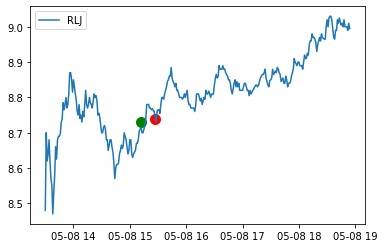

KIM analysis for run 549 with profit -98.54


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4066.67,-4066.67,buy,2020-05-08 15:23:11.595953,10.73,"[10.505, 10.53, 10.665]","[10.79, 10.82, 10.83, 10.84]",379,"{'avg': 10.6097, 'rsi': 69.88990042323947, 'macd': [0.005877001014342298, 0.012418893200450754, 0.017801641856799222, 0.024608050156139427, 0.029660272611108596], 'vwap': 10.7311, 'supports': [10.505, 10.53, 10.57, 10.59, 10.665], 'sell_macd': [0.005997756855748548, 0.010129355798827788, 0.013476973731112452, 0.017728663370151665, 0.020811425902257596], 'slow macd': [-0.00047742593977950776, 0.0008629389800187681, 0.0021747054432488255, 0.003937870501273366, 0.005553740679806296], 'macd_signal': [-0.01765601776495907, -0.011641035571877106, -0.00575250008614184, 0.00031960996231441413, 0.006187742492073251], 'resistances': [10.79, 10.82, 10.83, 10.84], 'position_ratio': '0.92', 'sell_macd_signal': [-0.0093905827678566, -0.0054865950545197216, -0.0016938812973932866, 0.0021906276361157036, 0.005914787289344083]}",11.48,10.48
1,-98.54,3968.13,sell,2020-05-08 15:57:55.564710,10.47,None,None,379,"{'avg': 10.6103, 'rsi': [26.75287501054109, 20.37770835242251], 'vwap': 10.4905, 'reasons': 'stopped', 'movement': -0.023299161230195712, 'sell_macd': [-0.0155869746061299, -0.01809010795043342, -0.020065405258328894, -0.02134400828709815, -0.02492027027981436], 'sell_macd_signal': [-0.007562500297358362, -0.009668021827973373, -0.011747498514044477, -0.013666800468655212, -0.015917494430887042]}",11.48,10.48


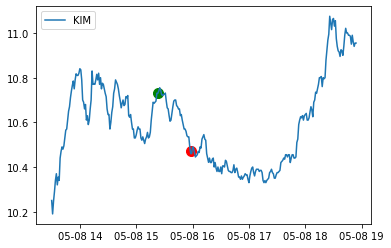

PBR analysis for run 549 with profit 18.91


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-12707.52,-12707.52,buy,2020-05-08 16:33:20.401010,6.72,"[6.6699, 6.675, 6.685]","[6.74, 6.75]",1891,"{'avg': 6.6495, 'rsi': 65.88002895953284, 'macd': [0.0030714744464956922, 0.004673961411951311, 0.005477346226345325, 0.006443219272080469, 0.007126530413073873], 'vwap': 6.72, 'supports': [6.62, 6.6699, 6.675, 6.685, 6.715], 'sell_macd': [0.0020961755067796517, 0.0031184824534049582, 0.00361484523709521, 0.004214415649879122, 0.0046268807033484904], 'slow macd': [0.0007703129362548466, 0.0011646178914741512, 0.001445560406625468, 0.001781692548063596, 0.002088095301864712], 'macd_signal': [0.0011377647809005737, 0.0018450041071107212, 0.002571472530957642, 0.0033458218791822076, 0.004101963585960541], 'resistances': [6.74, 6.75], 'position_ratio': '4.0', 'sell_macd_signal': [0.0008989387734400759, 0.0013428475094330525, 0.001797247054965484, 0.0022806807739482117, 0.0027499207598282675]}",6.87,6.67
1,18.91,12726.43,sell,2020-05-08 16:45:06.447546,6.73,None,None,1891,"{'avg': 6.6521, 'rsi': [58.46061901241203, 61.2528514628092], 'vwap': 6.74, 'reasons': 'bail', 'movement': 0.002976190476190545, 'sell_macd': [0.00853089146708097, 0.008464318372324975, 0.008562257280667396, 0.007748154387418715, 0.0072729033746608], 'sell_macd_signal': [0.006931561101830961, 0.007238112555929764, 0.00750294150087729, 0.0075519840781855755, 0.007496167937480621]}",6.87,6.67


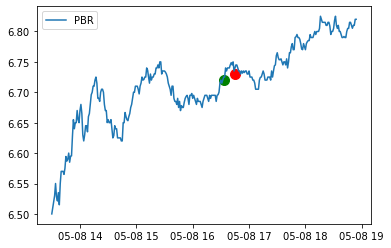

VST analysis for run 549 with profit 63.07


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-17064.94,-17064.94,buy,2020-05-08 17:09:56.483756,18.94,"[18.745, 18.84, 18.845, 18.845, 18.85, 18.86]",[19.11],901,"{'avg': 18.6603, 'rsi': 68.16296971980326, 'macd': [0.0001391183390424544, -0.00047513091102047156, 0.0002456154703942559, 0.003200666162722854, 0.00787256438420414], 'vwap': 18.9316, 'supports': [18.745, 18.84, 18.845, 18.845, 18.85, 18.86], 'sell_macd': [-0.00016270240699611804, -0.0005438426968495946, -5.455145911170689e-05, 0.0018858644593713336, 0.004931826675601769], 'slow macd': [0.010066836631615672, 0.009671553753893392, 0.009532316602093971, 0.009868776437077287, 0.010642354595631787], 'macd_signal': [0.0002915972261666324, 0.0001382515987292116, 0.00015972437306222047, 0.0007679127309943472, 0.0021888430616363056], 'resistances': [19.11, 19.14], 'position_ratio': '2.12', 'sell_macd_signal': [-0.00015059829771259936, -0.0002292471775399984, -0.0001943080338543401, 0.00022172646479079466, 0.0011637465069529896]}",19.26,18.83
1,63.07,17128.01,sell,2020-05-08 17:15:33.529794,19.01,None,None,901,"{'avg': 18.6648, 'rsi': [77.09512432786845, 79.06641783370914], 'vwap': 19.015, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.0039598732840548725, 'sell_macd': [0.011820774660510125, 0.015465096749146312, 0.018103982834457355, 0.019925141045945338, 0.02186467808027004], 'sell_macd_signal': [0.004433787107605582, 0.006640049035913729, 0.008932835795622453, 0.01113129684568703, 0.013277973092603632]}",19.26,18.83


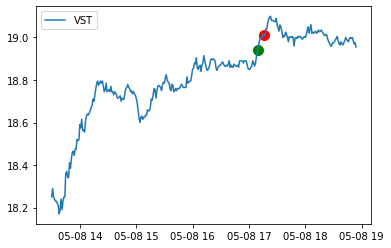

MAC analysis for run 549 with profit 0.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5475.66,-5475.66,buy,2020-05-08 15:18:05.631527,6.94,"[6.8, 6.83]",[6.98],789,"{'avg': 6.9074, 'rsi': 60.95853286322044, 'macd': [-0.0004172565108886417, 0.00048554062693106914, 0.0005092644172233207, 0.0031944125216725183, 0.006857199070495312], 'vwap': 6.94, 'supports': [6.8, 6.83, 6.915], 'sell_macd': [0.0010800607050480693, 0.0015923242294082485, 0.0015292526350210167, 0.0032005052545240886, 0.005500176058624184], 'slow macd': [0.0017310071936122995, 0.0017230934776577556, 0.001577111136866094, 0.0019760660306245015, 0.0026598289040418166], 'macd_signal': [-0.008770581514935804, -0.006919357086562429, -0.005433632785805279, -0.0037080237243097194, -0.0015949791653487129], 'resistances': [6.98, 7.06, 7.1], 'position_ratio': '1.6', 'sell_macd_signal': [-0.004247577054541081, -0.0030795967977512145, -0.002157826911196768, -0.0010861604780525967, 0.00023110682928275967]}",7.3,6.82
1,0.00,5475.66,sell,2020-05-08 15:33:49.768383,6.94,None,None,789,"{'avg': 6.9104, 'rsi': [62.367557187104886, 55.08624804841939], 'vwap': 6.9569, 'reasons': 'bail', 'movement': 0.0024351585014408777, 'sell_macd': [0.011580904736429254, 0.011913930807124551, 0.012252471501080109, 0.01258571786648588, 0.011481939477627101], 'sell_macd_signal': [0.010942706427139593, 0.011136951303136584, 0.01136005534272529, 0.011605187847477407, 0.011580538173507345]}",7.3,6.82


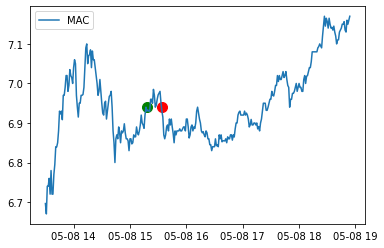

MIK analysis for run 549 with profit 0.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5808.44,-5808.44,buy,2020-05-08 16:57:17.856226,3.07,"[2.995, 3.005, 3.01, 3.03]","[3.18, 3.18]",1892,"{'avg': 2.9768, 'rsi': 66.12235537294517, 'macd': [0.0032576204724965585, 0.0037491062277426046, 0.00409144855760557, 0.005772868348151938, 0.007160044898031348], 'vwap': 3.062, 'supports': [2.995, 3.005, 3.01, 3.03], 'sell_macd': [0.0019193657255205387, 0.002232226451703845, 0.002447024076630111, 0.0035332686664864, 0.004422118104471906], 'slow macd': [0.004087020209562642, 0.004194778713178859, 0.00428721102104257, 0.004658077832842444, 0.005019026342486299], 'macd_signal': [0.00387808443418829, 0.0038522887928991527, 0.0039001207458404363, 0.004274670266302736, 0.004851745192648459], 'resistances': [3.18, 3.18, 3.19], 'position_ratio': '2.75', 'sell_macd_signal': [0.0023843701658426766, 0.0023539414230149104, 0.0023725579537379506, 0.0026047000962876403, 0.0029681836979244935]}",3.22,3.01
1,0.00,5808.44,sell,2020-05-08 17:09:07.082884,3.07,None,None,1892,"{'avg': 2.9796, 'rsi': [58.858463760218115, 58.85846376021813], 'vwap': 3.0732, 'reasons': 'bail', 'movement': 0.0016286644951141165, 'sell_macd': [0.007549340139920702, 0.007188781826665824, 0.0065547262341727475, 0.006235270886331801, 0.005905367097282177], 'sell_macd_signal': [0.005612031001781889, 0.005927381166758676, 0.00605285018024149, 0.006089334321459553, 0.0060525408766240775]}",3.22,3.01


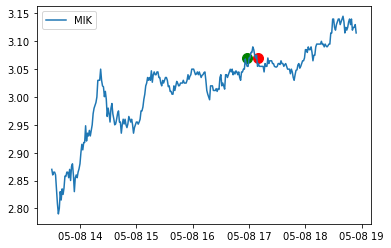

RUN analysis for run 549 with profit -109.8


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-9217.1,-9217.1,buy,2020-05-08 15:45:55.779824,15.11,"[14.985, 15.005]","[15.155, 15.16, 15.19, 15.19]",610,"{'avg': 14.9992, 'rsi': 59.249105568687966, 'macd': [-0.0034536343978892603, -0.0014112586088046442, 0.0010026968796097435, 0.004477987397546457, 0.007947482961201402], 'vwap': 15.1047, 'supports': [14.985, 15.005, 15.03, 15.06], 'sell_macd': [-0.0009715063791677636, 0.00030358980639810795, 0.001812709044418881, 0.004004065476065577, 0.006179095611425822], 'slow macd': [0.0011902752049515186, 0.001305934955102117, 0.0015701929900000522, 0.0021306795818993862, 0.002802873476193568], 'macd_signal': [-0.010666665483044633, -0.008815584108196635, -0.0068519279106353595, -0.004585944848998996, -0.0020792592869589162], 'resistances': [15.155, 15.16, 15.19, 15.19, 15.28, 15.29, 15.29, 15.35], 'position_ratio': '0.9', 'sell_macd_signal': [-0.005611461287460027, -0.0044284510686884, -0.0031802190460669443, -0.0017433621416404399, -0.00015887059102718724]}",15.57,14.96
1,-109.8,9107.3,sell,2020-05-08 15:57:23.623744,14.93,None,None,610,"{'avg': 15.0014, 'rsi': [36.356775083082674, 31.564551707602913], 'vwap': 14.945, 'reasons': 'stopped', 'movement': -0.010919920582395708, 'sell_macd': [-0.003490391139672866, -0.004734647278562321, -0.007720630668883288, -0.009947103042264871, -0.01337101524175388], 'sell_macd_signal': [0.0008961913457154558, -0.00022997637914009953, -0.0017281072370887373, -0.0033719063981239644, -0.005371728166849948]}",15.57,14.96


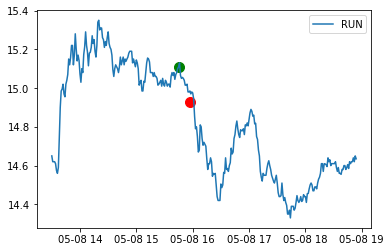

FHN analysis for run 549 with profit 8.59


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7662.28,-7662.28,buy,2020-05-08 15:15:30.191390,8.92,"[8.79, 8.83]",[9.08],859,"{'avg': 8.8719, 'rsi': 61.46103786942672, 'macd': [0.002190622692287647, 0.005383134126713429, 0.007424182867342921, 0.008938689055955962, 0.010821123374032737], 'vwap': 8.92, 'supports': [8.295, 8.79, 8.83, 8.88], 'sell_macd': [0.0023065335197944847, 0.004321132813077, 0.005575091576503155, 0.006479798514543944, 0.0076200922517877245], 'slow macd': [0.007122179106801241, 0.007545927255360851, 0.007843752437615592, 0.008105216145978034, 0.008492743986185047], 'macd_signal': [-0.0035653273809051734, -0.0017756350793814526, 6.432850996342218e-05, 0.00183920061916193, 0.003635585170136092], 'resistances': [9.08], 'position_ratio': '4.0', 'sell_macd_signal': [-0.0012935659266598547, -0.00017062617871248372, 0.0009785173723306441, 0.0020787736007733043, 0.0031870373309761885]}",9.25,8.81
1,8.59,7670.87,sell,2020-05-08 15:35:58.746506,8.93,None,None,859,"{'avg': 8.8804, 'rsi': [55.874127700699006, 54.105827013144214], 'vwap': 8.9396, 'reasons': 'bail', 'movement': 0.0016816143497758486, 'sell_macd': [0.011402143226190375, 0.012635143846345898, 0.012133129474438675, 0.011064895814842046, 0.009829065744833443], 'sell_macd_signal': [0.008346500375572332, 0.009204229069727045, 0.009790009150669372, 0.010044986483503906, 0.010001802335769814]}",9.25,8.81


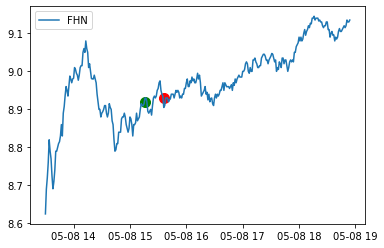

DFEN analysis for run 549 with profit 105.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-10920.0,-10920.0,buy,2020-05-08 15:08:32.701691,10.4,"[10.28, 10.34, 10.3517]","[10.4099, 10.5101]",1050,"{'avg': 10.3898, 'rsi': 57.934580961856255, 'macd': [0.0030150160420880923, 0.0013965952215162503, 0.001971375544753684, 0.003595817387235911, 0.006422991852005566], 'vwap': 10.41, 'supports': [10.28, 10.34, 10.3517], 'sell_macd': [0.002519673642579434, 0.0014196484541741938, 0.0017544385871808288, 0.0027717498780024385, 0.004567424262045705], 'slow macd': [0.02185438254583616, 0.020942252592137223, 0.020442220591405658, 0.020189384719335735, 0.020244349581187038], 'macd_signal': [-0.0013235745566598743, -0.0007795406010246493, -0.00022935737186898268, 0.0005356775799519961, 0.00171314043436271], 'resistances': [10.52, 10.57], 'position_ratio': '1.89', 'sell_macd_signal': [-0.000259251036158728, 7.652886190785642e-05, 0.0004121108069624509, 0.0008840386211704484, 0.0016207157493454997]}",10.68,10.32
1,105.0,11025.0,sell,2020-05-08 15:33:57.530801,10.5,None,None,1050,"{'avg': 10.3986, 'rsi': [66.3575214600888, 57.98613889563396], 'vwap': 10.5033, 'reasons': 'bail', 'movement': 0.009615384615384581, 'sell_macd': [0.023705349536957243, 0.02346665133434911, 0.02297589102927411, 0.022819767531432333, 0.02083811587686135], 'sell_macd_signal': [0.020507875549176293, 0.021099630706210855, 0.021474882770823506, 0.02174385972294527, 0.021562710953728487]}",10.68,10.32


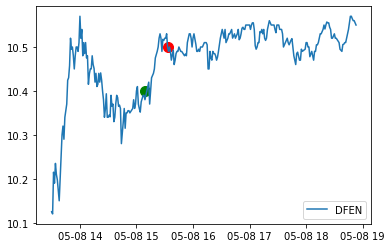

JETS analysis for run 549 with profit 21.84


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-9704.24,-9704.24,buy,2020-05-08 15:12:04.708497,13.33,[13.15],"[13.38, 13.3901]",728,"{'avg': 13.2383, 'rsi': 66.44625984531281, 'macd': [0.009110595561436341, 0.01085410864159897, 0.012096415372306879, 0.014527323319473595, 0.018659489678997332], 'vwap': 13.3261, 'supports': [13.15, 13.21, 13.32], 'sell_macd': [0.006672798994863172, 0.007719092455207743, 0.008434138106707678, 0.009920743314282277, 0.012508737718700758], 'slow macd': [0.009691669623393295, 0.010008903036652583, 0.010284760082539535, 0.010841980403315077, 0.011817108766566164], 'macd_signal': [0.0011035255558325661, 0.0030536421729858466, 0.004862196812850053, 0.006795222114174762, 0.009168075627139276], 'resistances': [13.38, 13.3901], 'position_ratio': '5.0', 'sell_macd_signal': [0.0016534999400497703, 0.002866618443081365, 0.003980122375806628, 0.005168246563501758, 0.006636344794541558]}",13.72,13.2
1,21.84,9726.08,sell,2020-05-08 15:27:27.701745,13.36,None,None,728,"{'avg': 13.2442, 'rsi': [68.44663189925507, 59.96886960813863], 'vwap': 13.35, 'reasons': 'bail', 'movement': 0.0015003750937734113, 'sell_macd': [0.01749449018868532, 0.017635132059632852, 0.01829491621803747, 0.018051956910067446, 0.016589235930998925], 'sell_macd_signal': [0.01549021901621009, 0.015919201624894644, 0.01639434454352321, 0.01672586701683206, 0.016698540799665432]}",13.72,13.2


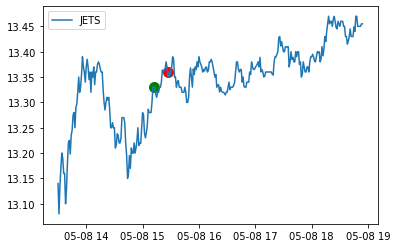

PINS analysis for run 549 with profit -124.53


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-11729.54,-11729.54,buy,2020-05-08 17:12:11.368403,19.78,"[19.48, 19.48, 19.575, 19.605]",[21.53],593,"{'avg': 19.4115, 'rsi': 66.61405425380966, 'macd': [0.03510953547971596, 0.03540659295292414, 0.029252930369793262, 0.034468688398735736, 0.03816230294108536], 'vwap': 19.8, 'supports': [19.48, 19.48, 19.49, 19.55, 19.575, 19.605], 'sell_macd': [0.021090899057693235, 0.02120855428790236, 0.01712869402198791, 0.020480378308004532, 0.022826101409989974], 'slow macd': [0.021719634425192424, 0.022526096558671327, 0.02203251998246003, 0.02362234414008313, 0.025047252580758794], 'macd_signal': [0.03272955863351333, 0.03326496549739549, 0.03246255847187505, 0.032863784457247185, 0.033923488154014816], 'resistances': [20.905, 21.05, 21.53], 'position_ratio': '5.67', 'sell_macd_signal': [0.019877353429129628, 0.020143593600884174, 0.019540613685104923, 0.019728566609684844, 0.02034807356974587]}",20.28,19.59
1,-124.53,11605.01,sell,2020-05-08 18:04:39.697230,19.57,None,None,593,"{'avg': 19.4537, 'rsi': [38.79075717451581, 32.25649150724721], 'vwap': 19.5752, 'reasons': 'stopped', 'movement': -0.010616784630940386, 'sell_macd': [-0.009200411662622088, -0.00815414473982301, -0.006973233569592452, -0.008819624429548867, -0.012741232574583705], 'sell_macd_signal': [-0.009843179187146287, -0.00950537229768163, -0.008998944552063796, -0.00896308052756081, -0.00971871093696539]}",20.28,19.59


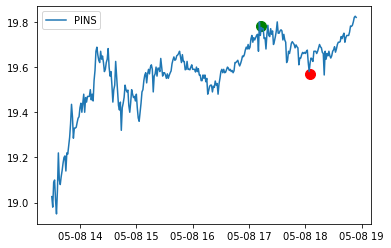

MTDR analysis for run 549 with profit 19.05


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4559.30,-4559.30,buy,2020-05-08 15:32:25.609370,7.18,"[7.0362, 7.0533, 7.055]","[7.18, 7.245, 7.269]",635,"{'avg': 7.1208, 'rsi': 67.54292957237547, 'macd': [0.01302943275120061, 0.01517263879677877, 0.017580305769276272, 0.021555767861469732, 0.024025935963769562], 'vwap': 7.1818, 'supports': [7.0362, 7.0533, 7.055, 7.11], 'sell_macd': [0.009222903115341907, 0.010514122336934939, 0.011970733128606525, 0.014441199549017014, 0.015918950012336452], 'slow macd': [0.00098368662738757, 0.0017702944490114447, 0.0026718951766238064, 0.003956139756203569, 0.005051390543323819], 'macd_signal': [0.0017953118675298366, 0.004470777253379623, 0.007092682956558953, 0.009985299937541109, 0.0127934271427868], 'resistances': [7.245, 7.269], 'position_ratio': '0.8', 'sell_macd_signal': [0.0021205300810221506, 0.0037992485322047085, 0.005433545451485072, 0.00723507627099146, 0.008971851019260459]}",7.63,7.04
1,19.05,4578.35,sell,2020-05-08 16:04:30.546979,7.21,None,None,635,"{'avg': 7.1263, 'rsi': [57.98560319412568, 57.98560319412569], 'vwap': 7.21, 'reasons': 'bail', 'movement': 0.004178272980501428, 'sell_macd': [0.013494715191624707, 0.014125335238135861, 0.01287484001154482, 0.012252702951713879, 0.011608794814810253], 'sell_macd_signal': [0.010680281430354915, 0.011369292191911105, 0.011670401755837848, 0.011786861995013054, 0.011751248558972494]}",7.63,7.04


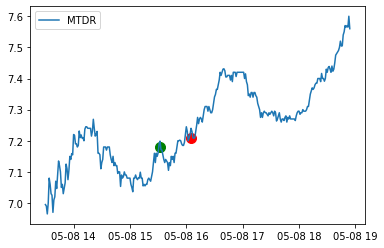

NRGU analysis for run 549 with profit -10.8


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4579.2,-4579.2,buy,2020-05-08 16:02:15.466941,4.24,"[4.18, 4.23]","[4.24, 4.2707]",1080,"{'avg': 4.1613, 'rsi': 62.880680844406115, 'macd': [-0.005332410301766899, -0.0023366215110165456, 0.0006593568465342869, 0.0029991192993561455, 0.005436265160691178], 'vwap': 4.248, 'supports': [4.12, 4.145, 4.16, 4.18, 4.2, 4.23], 'sell_macd': [-0.003276429652787627, -0.0013000874081825486, 0.0006619985929150474, 0.002182299391264131, 0.003754192229052933], 'slow macd': [0.0030322348111466724, 0.0033354867975896596, 0.003733903780242187, 0.004094488291222831, 0.004547637834046547], 'macd_signal': [-0.007132942615749475, -0.0061736783948028884, -0.0048070713465354535, -0.0032458332173571336, -0.0015094135417474711], 'resistances': [4.2707, 4.2754], 'position_ratio': '1.26', 'sell_macd_signal': [-0.004641027723246842, -0.003972839660233983, -0.0030458720096041766, -0.0020002377294305153, -0.0008493517377338256]}",4.51,4.16
1,-10.8,4568.4,sell,2020-05-08 16:46:35.569888,4.23,None,None,1080,"{'avg': 4.1663, 'rsi': [48.793517007895765, 51.18012132758879], 'vwap': 4.2443, 'reasons': 'bail', 'movement': 0.001014150943396167, 'sell_macd': [0.00559174837753762, 0.0050662547961994875, 0.0040663084367649205, 0.0032343202549087735, 0.0027673902397635786], 'sell_macd_signal': [0.003667942624589263, 0.003947605058911308, 0.00397134573448203, 0.0038239406385673787, 0.0036126305588066185]}",4.51,4.16


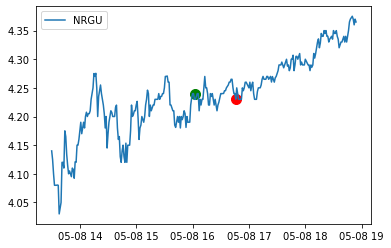

CLVS analysis for run 549 with profit 0.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3895.32,-3895.32,buy,2020-05-08 16:07:35.153267,9.08,[9.045],[9.0893],429,"{'avg': 9.018, 'rsi': 60.827316841890344, 'macd': [0.016501451645872578, 0.016373065196654935, 0.01627734287665028, 0.01702197817719764, 0.018209120043128024], 'vwap': 9.0733, 'supports': [8.91, 8.9581, 8.9903, 9.045, 9.0601, 9.07], 'sell_macd': [0.011401887331368599, 0.011182475885437526, 0.010990954292694255, 0.011353522476365896, 0.012008075314597022], 'slow macd': [-0.002132547464388068, -0.0015696371217810423, -0.0010108465392839605, -0.000293605229215288, 0.0005266853247185566], 'macd_signal': [0.010588618312454272, 0.011745507689294405, 0.01265187472676558, 0.013525895416851992, 0.014462540342107198], 'resistances': [9.0893, 9.09, 9.125, 9.14, 9.14, 9.17], 'position_ratio': '0.93', 'sell_macd_signal': [0.008010148140866511, 0.008644613689780714, 0.009113881810363423, 0.009561809943563917, 0.010051063017770537]}",9.74,8.86
1,0.00,3895.32,sell,2020-05-08 16:16:17.915514,9.08,None,None,429,"{'avg': 9.0193, 'rsi': [60.64925020980462, 58.82660095921928], 'vwap': 9.085, 'reasons': 'bail', 'movement': 0.0005506607929516279, 'sell_macd': [0.010802217730438102, 0.010669716633701753, 0.011472057121522994, 0.011428789227336367, 0.010986907891252784], 'sell_macd_signal': [0.010929399112569554, 0.010877462616795994, 0.010996381517741394, 0.01108286305966039, 0.011063672025978868]}",9.74,8.86


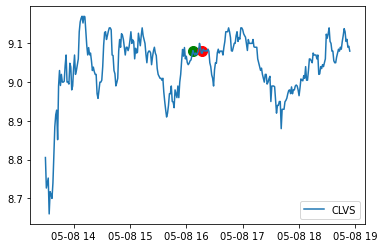

BLMN analysis for run 549 with profit 35.5


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7412.4,-7412.4,buy,2020-05-08 15:18:37.687324,10.44,"[10.3168, 10.33, 10.335]","[10.505, 10.61]",710,"{'avg': 10.2827, 'rsi': 61.52799753299798, 'macd': [-0.005696966060833475, -0.004212225357932198, -0.002602104005424266, 0.0026776446782257324, 0.00678368544543595], 'vwap': 10.44, 'supports': [9.85, 10.3168, 10.33, 10.335, 10.43], 'sell_macd': [-0.0030024888485638, -0.0020282610403814516, -0.0009830411763385172, 0.0024415852265029514, 0.005078416381619988], 'slow macd': [0.01932514202593616, 0.018795180950766266, 0.018357507557016817, 0.018725153894784796, 0.019033452018582864], 'macd_signal': [-0.01291857239737303, -0.011177302989484864, -0.009462263192672744, -0.007034281618493048, -0.004270688205707248], 'resistances': [10.505, 10.61], 'position_ratio': '6.5', 'sell_macd_signal': [-0.007997369524690798, -0.006803547827828929, -0.005639446497530847, -0.004023240152724087, -0.0022029088458552716]}",10.84,10.31
1,35.5,7447.9,sell,2020-05-08 15:34:12.694821,10.49,None,None,710,"{'avg': 10.3065, 'rsi': [59.702365849611105, 59.702365849611105], 'vwap': 10.495, 'reasons': 'bail', 'movement': 0.005268199233716448, 'sell_macd': [0.018577647443304812, 0.01830754982366578, 0.017339843239223995, 0.01662033365083815, 0.01584382833974729], 'sell_macd_signal': [0.01521627440171577, 0.015834529486105774, 0.016135592236729418, 0.016232540519551163, 0.01615479808359039]}",10.84,10.31


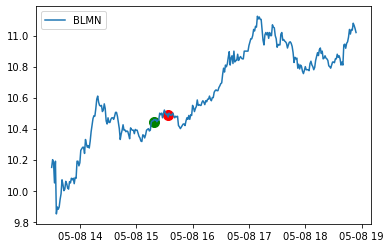

VTIQ analysis for run 549 with profit 0.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-8481.93,-8481.93,buy,2020-05-08 15:32:30.171759,16.93,"[16.58, 16.7601]",[17.22],501,"{'avg': 16.6769, 'rsi': 60.89997049015648, 'macd': [0.0060059635273148615, 0.007506095292516335, 0.008595872655082104, 0.01057224098580889, 0.014776264709475129], 'vwap': 16.93, 'supports': [15.6218, 16.58, 16.71, 16.7601, 16.83, 16.89], 'sell_macd': [0.005597603354086544, 0.006453061839259533, 0.007035846868756579, 0.008193395633703915, 0.010796766156602189], 'slow macd': [0.03452074327634236, 0.033847614492380274, 0.03317417995025096, 0.03274624328442144, 0.032856732192371396], 'macd_signal': [-0.00757716728406722, -0.004560514768750509, -0.0019292372839839864, 0.0005710583699745889, 0.003412099637874697], 'resistances': [17.0, 17.0, 17.025, 17.2094, 17.22], 'position_ratio': '1.75', 'sell_macd_signal': [-0.0031418080085414955, -0.0012228340389812899, 0.00042890214256628397, 0.00198180084079381, 0.0037447939039554857]}",17.5,16.74
1,0.00,8481.93,sell,2020-05-08 15:45:06.172177,16.93,None,None,501,"{'avg': 16.6871, 'rsi': [55.91806151615769, 55.91806151615768], 'vwap': 16.935, 'reasons': 'bail', 'movement': 0.0002953337271115774, 'sell_macd': [0.010528733531913304, 0.010016770810523212, 0.010007231406707007, 0.010129574320529855, 0.01009335354791574], 'sell_macd_signal': [0.013457514778524967, 0.012769365984924615, 0.012216939069281094, 0.011799466119530847, 0.011458243605207825]}",17.5,16.74


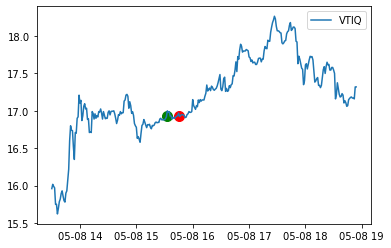

ERX analysis for run 549 with profit 9.96


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7873.38,-7873.38,buy,2020-05-08 15:12:49.757615,15.81,"[15.56, 15.641]","[15.92, 15.92]",498,"{'avg': 15.7123, 'rsi': 63.240012636135965, 'macd': [0.0018685351983087628, 0.0047710045751312435, 0.00778836941936234, 0.013254528548952038, 0.01898152469266101], 'vwap': 15.81, 'supports': [15.538, 15.56, 15.56, 15.641, 15.67, 15.81], 'sell_macd': [0.002265016429607414, 0.004079773576215473, 0.005960366501152947, 0.009426278306285951, 0.013043530643969348], 'slow macd': [0.01655425184436332, 0.016621947414490634, 0.016817581047920527, 0.017610416980080146, 0.018631558048443964], 'macd_signal': [-0.003101786447589879, -0.0015272282430456542, 0.0003358912894359449, 0.002919618741339164, 0.006131999931603534], 'resistances': [15.92, 15.92], 'position_ratio': 'inf', 'sell_macd_signal': [-0.0008142132281413788, 0.00016458413272999156, 0.0013237406064145825, 0.0029442481463888563, 0.004964104645904955]}",16.38,15.62
1,9.96,7883.34,sell,2020-05-08 16:44:37.809774,15.83,None,None,498,"{'avg': 15.7384, 'rsi': [57.26957874898708, 50.89136536274032], 'vwap': 15.83, 'reasons': 'bail', 'movement': 0.001265022137887386, 'sell_macd': [0.012533727551657492, 0.013032579713508241, 0.012213080362826645, 0.0114158980069341, 0.009607497495759176], 'sell_macd_signal': [0.00818096274214139, 0.00915128613641476, 0.009763644981697137, 0.010094095586744529, 0.009996775968547459]}",16.38,15.62


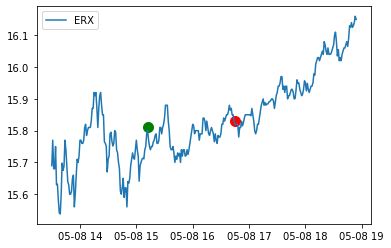

GPS analysis for run 549 with profit 13.52


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-10721.36,-10721.36,buy,2020-05-08 16:39:48.576493,7.93,"[7.845, 7.87, 7.89]",[7.98],1352,"{'avg': 7.8263, 'rsi': 61.61498827202871, 'macd': [-0.00035994632254876535, 0.001101433808447183, 0.0030315585970228653, 0.0037114961539188585, 0.005797356106997498], 'vwap': 7.9203, 'supports': [7.685, 7.73, 7.765, 7.84, 7.845, 7.87, 7.89], 'sell_macd': [-0.000607723386118586, 0.0003756336767697377, 0.0016564880936078552, 0.0021135631184998616, 0.0034812376428501324], 'slow macd': [0.007864596796447465, 0.00794281052873913, 0.008162002274395341, 0.008190675684095261, 0.008523828348223184], 'macd_signal': [-0.00036865033582962685, -7.463350697426487e-05, 0.0005466049138251612, 0.0011795831618439006, 0.00210313775087462], 'resistances': [7.98], 'position_ratio': '1.25', 'sell_macd_signal': [-0.0007565145776972117, -0.0005300849268038218, -9.277032272148641e-05, 0.0003484963655227832, 0.000975044620988253]}",8.14,7.86
1,13.52,10734.88,sell,2020-05-08 17:27:18.827594,7.94,None,None,1352,"{'avg': 7.8387, 'rsi': [54.44416514368644, 49.3961375177908], 'vwap': 7.9481, 'reasons': 'bail', 'movement': 0.001261034047919379, 'sell_macd': [0.007701402475616348, 0.008149295918387978, 0.008163897355374594, 0.0072588608471129135, 0.005939886154348706], 'sell_macd_signal': [0.004512682674251903, 0.005240005323079118, 0.005824783729538213, 0.006111599153053153, 0.006077256553312264]}",8.14,7.86


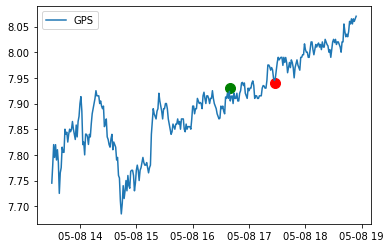

ORC analysis for run 549 with profit -8251.6


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-8251.6,-8251.6,buy,2020-05-08 17:12:43.060759,3.92,"[3.855, 3.8801, 3.885, 3.89, 3.9053]","[3.935, 3.94, 3.95, 3.95]",2105,"{'avg': 3.8616, 'rsi': 65.1729397466101, 'macd': [0.0027282419114729173, 0.0030242364409005518, 0.0036205371526638608, 0.004684641275525259, 0.005624499021065876], 'vwap': 3.92, 'supports': [3.855, 3.8801, 3.885, 3.89, 3.9053], 'sell_macd': [0.001722058911212354, 0.0019037070708018966, 0.002280267882549758, 0.002959662438683619, 0.0035545197234805315], 'slow macd': [-5.487347402777232e-05, 0.00010229459728350321, 0.00032669865713863544, 0.000660583881888055, 0.0009986996622246558], 'macd_signal': [0.0018920839647574082, 0.002118514459986037, 0.0024189189985216017, 0.002872063453922333, 0.003422550567351042], 'resistances': [3.935, 3.94, 3.95, 3.95], 'position_ratio': '1.02', 'sell_macd_signal': [0.0012276534029607678, 0.0013628641365289935, 0.0015463448857331464, 0.001829008396323241, 0.002174110661754699]}",4.05,3.88


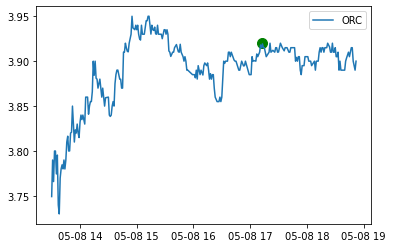

In [13]:
for run_id, count in runs.items():
    for symbol in minute_history:    
        if symbol not in trade_details[run_id]:
            continue
        start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d") + timedelta(hours=9, minutes=30)
        minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
        plt.plot(minute_history[symbol]["close"][minute_history_index:], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        target_price = []
        stop_price = []
        resistances = []
        supports = []
        for trade in trade_details[run_id][symbol]:
            resistance = None
            support = None
            if trade[0] == 'buy':
                resistance = find_resistance(trade[2], minute_history[symbol], trade[1])
                support = find_support(trade[2], minute_history[symbol], trade[1])
                
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
            target_price.append(trade[6])
            stop_price.append(trade[5])    
            resistances.append(resistance)
            supports.append(support)
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'support': supports,
            'resistance': resistances,
            'qty': qtys,
            'indicators': indicators,
            'target price': target_price,
            'stop price': stop_price
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

In [ ]:
 pd.Timestamp('2020-04-16 13:44:06.066') 

In [ ]:
index = minute_history['NURO'].index.get_loc(pd.Timestamp('2020-04-16 13:44:06.066') , method='nearest')

In [ ]:
minute_history['NURO'][:index]

In [ ]:
series = minute_history['NURO'][:2417]['close']

In [ ]:
MACD(series.dropna().between_time("9:30", "16:00"))